In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels .stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")

from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [ ]:
query = '''CREATE TABLE datamarts.mekhtiev_watchtime_analyse_local ON CLUSTER 'viasat_cluster'
            (
                date_week Date,
                user_id UUID,
                profile_id UUID,
                watchtime Int32,
                active_day Int32,
                watch_day Int32,
                viewing_cnt Int32,
                viewing_watch_cnt Int32
             )
             ENGINE = ReplicatedMergeTree('/clickhouse/tables/{shard}/datamarts.mekhtiev_watchtime_analyse_local', '{replica}')
             ORDER BY date_week
             '''
execute(query,user = 'kmekhtiev')

In [ ]:
query = f'''CREATE TABLE datamarts.mekhtiev_watchtime_analyse_distr ON CLUSTER 'viasat_cluster'
            (
                date_week Date,
                user_id UUID,
                profile_id UUID,
                watchtime Int32,
                active_day Int32,
                watch_day Int32,
                viewing_cnt Int32,
                viewing_watch_cnt Int32
             )
             ENGINE = Distributed(viasat_cluster, datamarts, mekhtiev_watchtime_analyse_local, rand())
             '''
execute(query,user = 'kmekhtiev')

In [3]:
list_date = pd.date_range("2024-04-01", "2024-08-08", freq='D')
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query_delete = f" DELETE FROM datamarts.mekhtiev_watchtime_analyse_local  ON CLUSTER 'viasat_cluster' WHERE date_week = '{date}'::date"
    execute(query_delete,user = 'kmekhtiev')
    print(f'Дата {date_str} удалена из таблицы')
    query = f"""INSERT INTO datamarts.mekhtiev_watchtime_analyse_distr
                SELECT 
                t1.date_week,
                t1.user_id,
                t1.profile_id,
                t2.watchtime,
                t1.active_day,
                t2.watch_day,
                t2.viewing_cnt,
                t2.viewing_watch_cnt
                FROM 
                (SELECT
                                '{date_str}' AS date_week,
                                user_id,
                                profile_id,
                                uniq(date) as active_day
                                FROM
                                datamarts.sandbox_data_distr AS t1
                                LEFT JOIN product_x.users AS u ON t1.user_id=u.id
                                WHERE client_type!='backend' 
                                AND reg_date!='1970-01-01'
                                AND date BETWEEN '{date}'::date - interval '6' DAY AND '{date}'::date
                                AND profile_id IS NOT NULL  
                                AND (u.email NOT LIKE '%@test%' OR u.email IS NULL)
                                AND (promo_type IS NULL OR promo_type!='cards')
                                GROUP BY 1,2,3
                                ) AS t1

                    LEFT JOIN (SELECT 
                                 date_week,
                                 profile_id,
                                 viewing_cnt,
                                 viewing_watch_cnt,
                                 count(DISTINCT CASE WHEN viewing_time>30 THEN date END) AS watch_day,
                                 sum(viewing_time) AS watchtime
                                 FROM 
                                     (SELECT 
                                        date_week,
                                        date,
                                        profile_id,
                                        viewing_cnt,
                                        viewing_watch_cnt,
                                        COALESCE(sum(viewing_time),0) AS viewing_time
                                        FROM 
                                                    (SELECT 
                                                    date_week,
                                                    date,
                                                    profile_id,
                                                    item_type,
                                                    item_title,
                                                    viewing_time,
                                                    viewing_cnt,
                                                    COALESCE(count(DISTINCT CASE WHEN viewing_time_per_item>30 THEN item_title END) OVER (PARTITION BY date_week,profile_id),0) AS viewing_watch_cnt    
                                                    FROM  
                                                            (SELECT 
                                                             '{date_str}' AS date_week,
                                                            date,
                                                            profile_id,
                                                            event_name,
                                                            event_page,
                                                            u.email,
                                                            JSONExtractInt(payload,'duration') AS duration,
                                                            JSONExtractString(payload,'item_type') AS item_type,
                                                            JSONExtractString(payload,'item_title') AS item_title,
                                                            CASE WHEN event_page<>'tvchannel'
                                                                      AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration') 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                                 WHEN event_page='tvchannel' 
                                                                      AND JSONExtractInt(payload,'viewing_time') <18000 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                            END AS viewing_time,
                                                            count(DISTINCT item_title) OVER (PARTITION BY date_week,profile_id) AS viewing_cnt,
                                                            sum(viewing_time) OVER (PARTITION BY date_week,profile_id,item_title) AS viewing_time_per_item                                      		 
                                                            FROM datamarts.sandbox_data_distr AS t1
                                                            LEFT JOIN product_x.users AS u ON t1.user_id=u.id
                                                            WHERE date BETWEEN '{date}'::date - interval '6' DAY AND '{date}'::date
                                                            AND event_name IN ('auto_player_streaming','auto_kinom_streaming')
                                                            AND viewing_time IS NOT NULL  
                                                            AND (promo_type IS NULL OR promo_type!='cards')
                                                             )
                                                        )
                                         GROUP BY 1,2,3,4,5
                                        )
                                     GROUP BY 1,2,3,4
                                     ) AS t2
                                     
        ON t1.date_week=t2.date_week
        AND t1.profile_id=t2.profile_id
        """
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df = pd.concat(result)

Время выполнения функции: 0.908 секунд

Дата 2024-04-01 удалена из таблицы
Время выполнения функции: 11.562 секунд

Дата '2024-04-01' загружена

Время выполнения функции: 0.4581 секунд

Дата 2024-04-02 удалена из таблицы
Время выполнения функции: 13.2572 секунд

Дата '2024-04-02' загружена

Время выполнения функции: 0.345 секунд

Дата 2024-04-03 удалена из таблицы
Время выполнения функции: 13.2012 секунд

Дата '2024-04-03' загружена

Время выполнения функции: 1.4834 секунд

Дата 2024-04-04 удалена из таблицы
Время выполнения функции: 12.6231 секунд

Дата '2024-04-04' загружена

Время выполнения функции: 0.408 секунд

Дата 2024-04-05 удалена из таблицы
Время выполнения функции: 11.4012 секунд

Дата '2024-04-05' загружена

Время выполнения функции: 1.8267 секунд

Дата 2024-04-06 удалена из таблицы
Время выполнения функции: 12.729 секунд

Дата '2024-04-06' загружена

Время выполнения функции: 1.887 секунд

Дата 2024-04-07 удалена из таблицы
Время выполнения функции: 12.7567 секунд

Дата '

In [6]:
query = f"""SELECT 
                t1.date_week,
                t1.user_id,
                t1.profile_id,
                t1.watchtime,
                t2.trial_duration,
                t1.viewing_cnt,
                t1.viewing_watch_cnt,
                t2.reg_date,
                t2.min_date,
                t2.created_date,
                t2.first_prolong_date
                FROM 
                (SELECT * FROM datamarts.mekhtiev_watchtime_analyse_distr
                WHERE date_week BETWEEN '2024-04-01' AND '2024-07-31'
                ) AS t1
                LEFT JOIN (SELECT date_week,profile_id,trial_duration,reg_date,min_date,created_date,first_prolong_date
                           FROM  datamarts.mekhtiev_registration_distr
                           WHERE date_week BETWEEN '2024-04-01' AND '2024-07-31'
                           group by 1,2,3,4,5,6,7
                           ) AS t2
                ON t1.profile_id=t2.profile_id AND t1.date_week=t2.date_week
        """
df = execute(query,user = 'kmekhtiev')
df['date_week'] = df['date_week'].astype('datetime64[ns]')
for i in df.columns[7:]:
    df[i] = df[i].astype('datetime64[ns]')

Время выполнения функции: 13.1203 секунд



In [101]:
query="""						SELECT DISTINCT profile_id
                        FROM datamarts.marketing_dash_distr x 
                        WHERE reg_date!='1970-01-01' 
                        AND reg_date BETWEEN '2024-04-01'  AND '2024-07-31'::date
                        AND (promo_type IS NULL OR promo_type!='cards')
                        """
df_check=execute(query,user='kmekhtiev')

Время выполнения функции: 0.7043 секунд



In [109]:
df2 = df[df['reg_date']>='2024-04-01-']['profile_id'].drop_duplicates().reset_index()

df_merge = pd.merge(df_check['profile_id'],df2['profile_id'],how='left',on='profile_id',indicator='profile_type')
df_merge[df_merge.profile_type=='left_only']

,profile_id,profile_type
7,ef07c7ce-a8b4-430a-ac1d-e0d648078aa8,left_only
54,b17cc4ff-d014-497c-8d80-c6793cd13321,left_only
135,53509e5b-9314-417e-8854-4702e4d3527d,left_only
157,50533eb6-c911-4927-8fb3-671e00273994,left_only
204,5620af5a-1bf4-4916-bff7-73894bb2f4ab,left_only
...,...,...
67963,163cad02-cf9f-4749-bcca-9d9fe88973a8,left_only
67965,a8233b5d-a6fb-4753-a19f-c65067cf48f3,left_only
67968,fed27cef-0b1d-4c6f-99d6-0917dae846db,left_only
67970,84119dfb-2dbb-4338-81f4-497dbe033927,left_only


In [164]:
df['dt_diff'] = (df['date_week'] - df['min_date']).dt.days
df_w_new = df[df.min_date!='1970-01-01']
df_w_new['max']= df_w_new[df_w_new.dt_diff<=6].groupby('profile_id')['dt_diff'].transform('max')
df_w_new_max = df_w_new[(df_w_new['max']==df_w_new['dt_diff']) & (df_w_new['max']<=6)]
df_w_new_max[['watchtime','viewing_cnt','viewing_watch_cnt']].describe()

,watchtime,viewing_cnt,viewing_watch_cnt
count,70091.000000,70091.000000,70091.000000
mean,1212.236464,3.378223,0.562982
std,7679.360015,7.208056,1.698978
min,-8.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,1.000000,0.000000
75%,58.000000,3.000000,0.000000
max,493581.000000,209.000000,52.000000


In [168]:
df_w_new_max[df_w_new_max.reg_date>='2024-04-01']['profile_id'].nunique()

62294

In [170]:
df_w_new_max = df_w_new_max[df_w_new_max['reg_date']!='1970-01-01']
df_w_new_max['new_profile'] = np.where((df_w_new_max.reg_date!='1970-01-01') & (df_w_new_max.reg_date<=df_w_new_max.min_date),1,0)
df_w_new_max['new_trial'] = np.where((df_w_new_max.created_date!='1970-01-01') & (df_w_new_max.created_date<=df_w_new_max.min_date) & (df_w_new_max.trial_duration!='0'),1,0)
df_w_new_max['new_subs'] = np.where((df_w_new_max.created_date!='1970-01-01') & (df_w_new_max.first_prolong_date!='1970-01-01'),1,0)


In [172]:
# Определяем условия для viewing_cnt
conditions = [  
    df_w_new_max['viewing_cnt'] == 0,  
    df_w_new_max['viewing_cnt'] == 1,  
    (df_w_new_max['viewing_cnt'] > 1) & (df_w_new_max['viewing_cnt'] <= 5),  
    df_w_new_max['viewing_cnt'] > 5 
    ]  
# Определяем соответствующие значения для каждого условия  
choices = ['0', '1', '2-5', '5+']  
# Применяем np.select для создания новом столбца  
df_w_new_max['segments'] = np.select(conditions, choices, default='unknown')  



# Определяем условия для viewing_watch_cnt
conditions = [  
    df_w_new_max['viewing_watch_cnt'] == 0,  
    df_w_new_max['viewing_watch_cnt'] == 1,  
    (df_w_new_max['viewing_watch_cnt'] > 1) & (df_w_new_max['viewing_watch_cnt'] <= 5),  
    df_w_new_max['viewing_watch_cnt'] > 5 
    ]    
df_w_new_max['segments_watch'] = np.select(conditions, ['0', '1', '2-5', '5+'], default='unknown')  

In [692]:
def grafics(segment):
    t1 = df_w_new_max.groupby(segment)['profile_id'].nunique().reset_index()
    t1.rename(columns={'profile_id': 'cnt_register'}, inplace=True)
    t1['frac_register'] = t1.cnt_register / t1.cnt_register.sum()

    t2 = df_w_new_max[df_w_new_max.new_trial == 1].groupby(segment)['profile_id'].nunique().reset_index()
    t2.rename(columns={'profile_id': 'cnt_trial'}, inplace=True)
    t2['frac_trial'] = t2.cnt_trial / t2.cnt_trial.sum()

    t1 = pd.merge(t1, t2, how='left', on=segment)
    t1['register_to_trial'] = t1.cnt_trial / t1.cnt_register
    
    t3 = df_w_new_max[df_w_new_max.new_subs == 1].groupby(segment)['profile_id'].nunique().reset_index()
    t3.rename(columns={'profile_id': 'cnt_subs'}, inplace=True)
    t3['frac_subs'] = t3.cnt_subs / t3.cnt_subs.sum()

    t1 = pd.merge(t1, t3, how='left', on=segment)
    t1['trial_to_subs'] = t1.cnt_subs / t1.cnt_trial

    # Создание графиков в виде подграфиков
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))

    labels = t1[segment] 
    values = [t1['frac_register'][0], t1['frac_register'][1], t1['frac_register'][2],t1['frac_register'][3]]
     
    axs[0,0].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(t1))),textprops={'color':'white'})  
    axs[0,0].set_title('Доля новых зарегистрированных по сегментам')  
    axs[0,0].axis('equal')  # Обеспечить, чтобы круг был кругом  

    bars2 = axs[0,1].bar(t1[segment], t1['cnt_register'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
    axs[0,1].set_title('Число новых зарегистрированных по сегментам')
    axs[0,1].set_ylabel('Число зарегов')
    axs[0,1].set_xticklabels(t1[segment], rotation=45)
    axs[0,1].grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars2:
        yval = bar.get_height()
        axs[0,1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')


    values2 = [t1['frac_trial'][0], t1['frac_trial'][1], t1['frac_trial'][2],t1['frac_trial'][3]]
    axs[1,0].pie(values2, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(t1))),textprops={'color':'white'})  
    axs[1,0].set_title('Доля новых триал по сегментам')  
    axs[1,0].axis('equal')

    bars4 = axs[1,1].bar(t1[segment], t1['cnt_trial'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
    axs[1,1].set_title('Число триалов по сегментам')
    axs[1,1].set_ylabel('Число триалов')
    axs[1,1].set_xticklabels(t1[segment], rotation=45)
    axs[1,1].grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars4:
        yval = bar.get_height()
        axs[1,1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')

    bars5 = axs[2,0].bar(t1[segment], t1['register_to_trial'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
    axs[2,0].set_title('Конверсия из регистрации в триалам по сегментам')
    axs[2,0].set_ylabel('Доля')
    axs[2,0].set_xticklabels(t1[segment], rotation=45)
    axs[2,0].set_yticks(np.arange(0, 1.1, 0.1))
    axs[2,0].set_yticklabels([f'{int(i * 100)}%' for i in np.arange(0, 1.1, 0.1)])
    axs[2,0].grid(axis='y', linestyle='--', alpha=0.7)

    axs[2, 1].remove()  # Удаляем ось [2,1]

    for bar in bars5:
        yval = bar.get_height()
        axs[2,0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom')
        
    values2 = [t1['frac_subs'][0], t1['frac_subs'][1], t1['frac_subs'][2],t1['frac_subs'][3]]
    axs[3,0].pie(values2, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(t1))),textprops={'color':'white'})  
    axs[3,0].set_title('Доля новых подписчиков по сегментам')  
    axs[3,0].axis('equal')

    

    bars7 = axs[3,1].bar(t1[segment], t1['cnt_subs'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))    
    axs[3,1].set_title('Число подписчиков по сегментам')  
    axs[3,1].set_ylabel('Число подписчиков')  
    axs[3,1].set_xticklabels(t1[segment], rotation=45)  
    axs[3,1].grid(axis='y', linestyle='--', alpha=0.7)  
        
    for bar in bars7:  
            yval = bar.get_height()  
            axs[3,1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')
    
            

    bars8 = axs[4,0].bar(t1[segment], t1['trial_to_subs'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))   
    axs[4,0].set_title('Конверсия из триала в подписку')  
    axs[4,0].set_ylabel('Доля')  
    axs[4,0].set_xticklabels(t1[segment], rotation=45)  
    axs[4,0].set_yticks(np.arange(0, 1.1, 0.1), [f'{int(i * 100)}%' for i in np.arange(0, 1.1, 0.1)])  
    axs[4,0].grid(axis='y', linestyle='--', alpha=0.7)  

    for bar in bars8:  
            yval = bar.get_height()  
            axs[4,0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom') 
    axs[4, 1].remove()  # Удаляем ось [2,1]
    
    # Добавление текста между зонами
    fig.text(0.15, 1.01, 'Графики по зарегам', ha='center', va='center', fontsize=14, bbox=dict(facecolor='lightgrey', alpha=0.5))
    fig.text(0.15, 0.81, 'Графики по триалам', ha='center', va='center', fontsize=14, bbox=dict(facecolor='lightgrey', alpha=0.5))
    fig.text(0.15, 0.40, 'Графики по подписчикам', ha='center', va='center', fontsize=14, bbox=dict(facecolor='lightgrey', alpha=0.5))
 
    # Увеличение расстояния между подграфиками
    plt.tight_layout()
    plt.show()


## Гипотеза 1 - ииследовать новых пользователей в разбивке по сегментам показаных видео

1. **Анализ новых пользователей** с разбивкой по сегментам просмотра:  
   - 0 видео просмотрено  
   - 1 видео просмотрено  
   - 2-5 видео просмотрено  
   - 5+ видео просмотрено  

### Цель исследования  
Выяснить, какие паттерны поведения демонстрируют новые пользователи в зависимости от количества видео,которые были показаны, и на основании этих данных улучшить онбординг для новых пользователей.  

### Определения  

- **Новый пользователь**: пользователь, который впервые зашел в приложение и зарегистрировался в течение 1 недели после первого посещения.  
- **Период анализа**: с 01.04.2024 по 01.08.2024.  
- **Типы видео**: все форматы видео (тв, фильмы, сериалы, киномы).  
- **Просмотр**: считается смотрение, если пользователь смотрел хотя бы один тайтл более **30 секунд** в течение недели.  

## Методология  

Анализ будет проводиться по двум основным срезам:  

1. **По сегментам просмотра**:  
   - Все новые пользователи с разбивкой по количеству видео смотрения: **0, 1, 2-5, 5+**.  
   
2. **По смотрению**:  
   - Все новые пользователи с разбивкой по количеству просмотренных видео: **0, 1, 2-5, 5+**.  

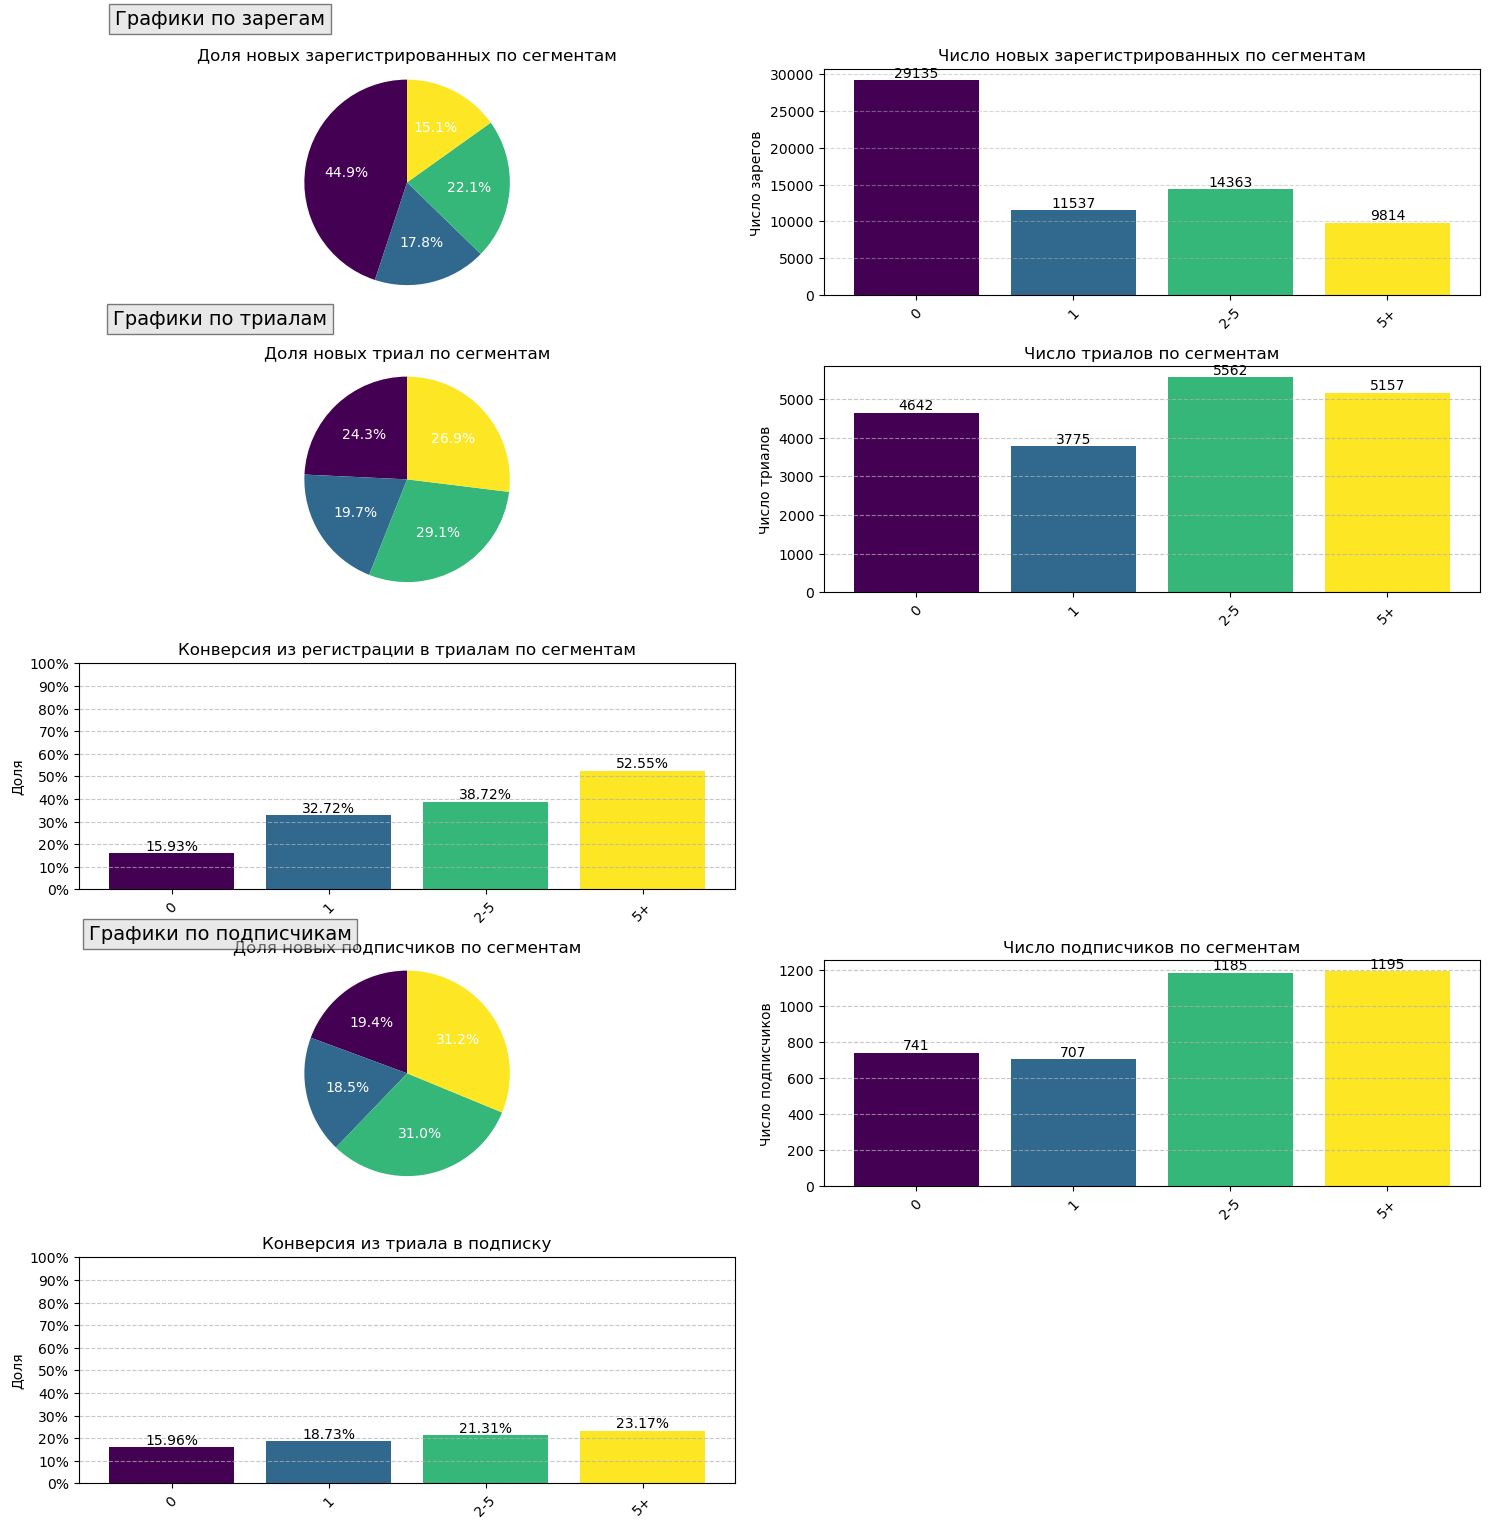

In [713]:
grafics('segments')

In [236]:
def trial_type(segment):
        df_trial = df_w_new_max[(df_w_new_max['new_trial']==1) & (df_w_new_max['trial_duration'].isin(['3','14','30','35','45']))].groupby([segment,'trial_duration'])['profile_id'].nunique().reset_index()
        df_trial['sum'] = df_trial.groupby(segment)['profile_id'].transform('sum')
        df_trial['frac_trial'] = df_trial['profile_id']/df_trial['sum']



        plt.figure(figsize=(20, 8))  # Устанавливаем размер фигуры  

        # Строим barplot с использованием Seaborn  
        sns.barplot(data=df_trial, x=segment, y='frac_trial', hue='trial_duration', ci=None)  

        # Настраиваем заголовок и метки  
        plt.title('Сегменты в разбивке по длительности триалов')  
        plt.xlabel('Сегменты')  
        plt.ylabel('Доля')  
        plt.legend(title='Триалы')  
        plt.xticks(rotation=45)
        plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(i * 100)}%' for i in np.arange(0, 1.1, 0.1)])  

        # Отображаем график  
        plt.tight_layout()  
        plt.show()  

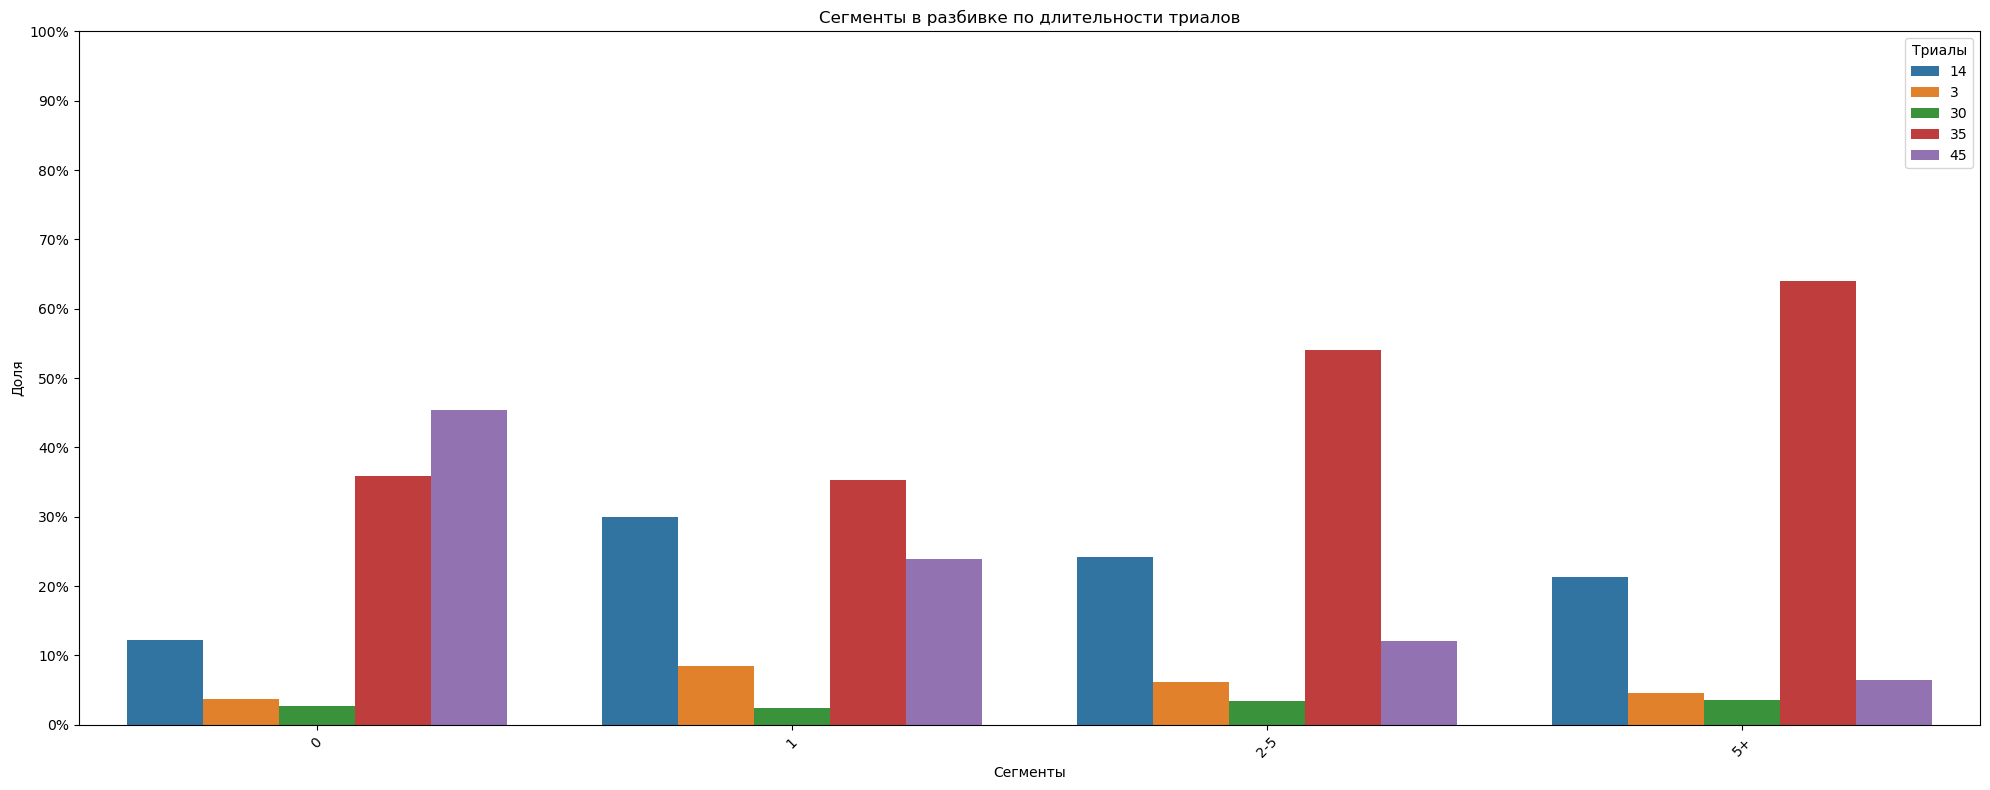

In [377]:
trial_type('segments')

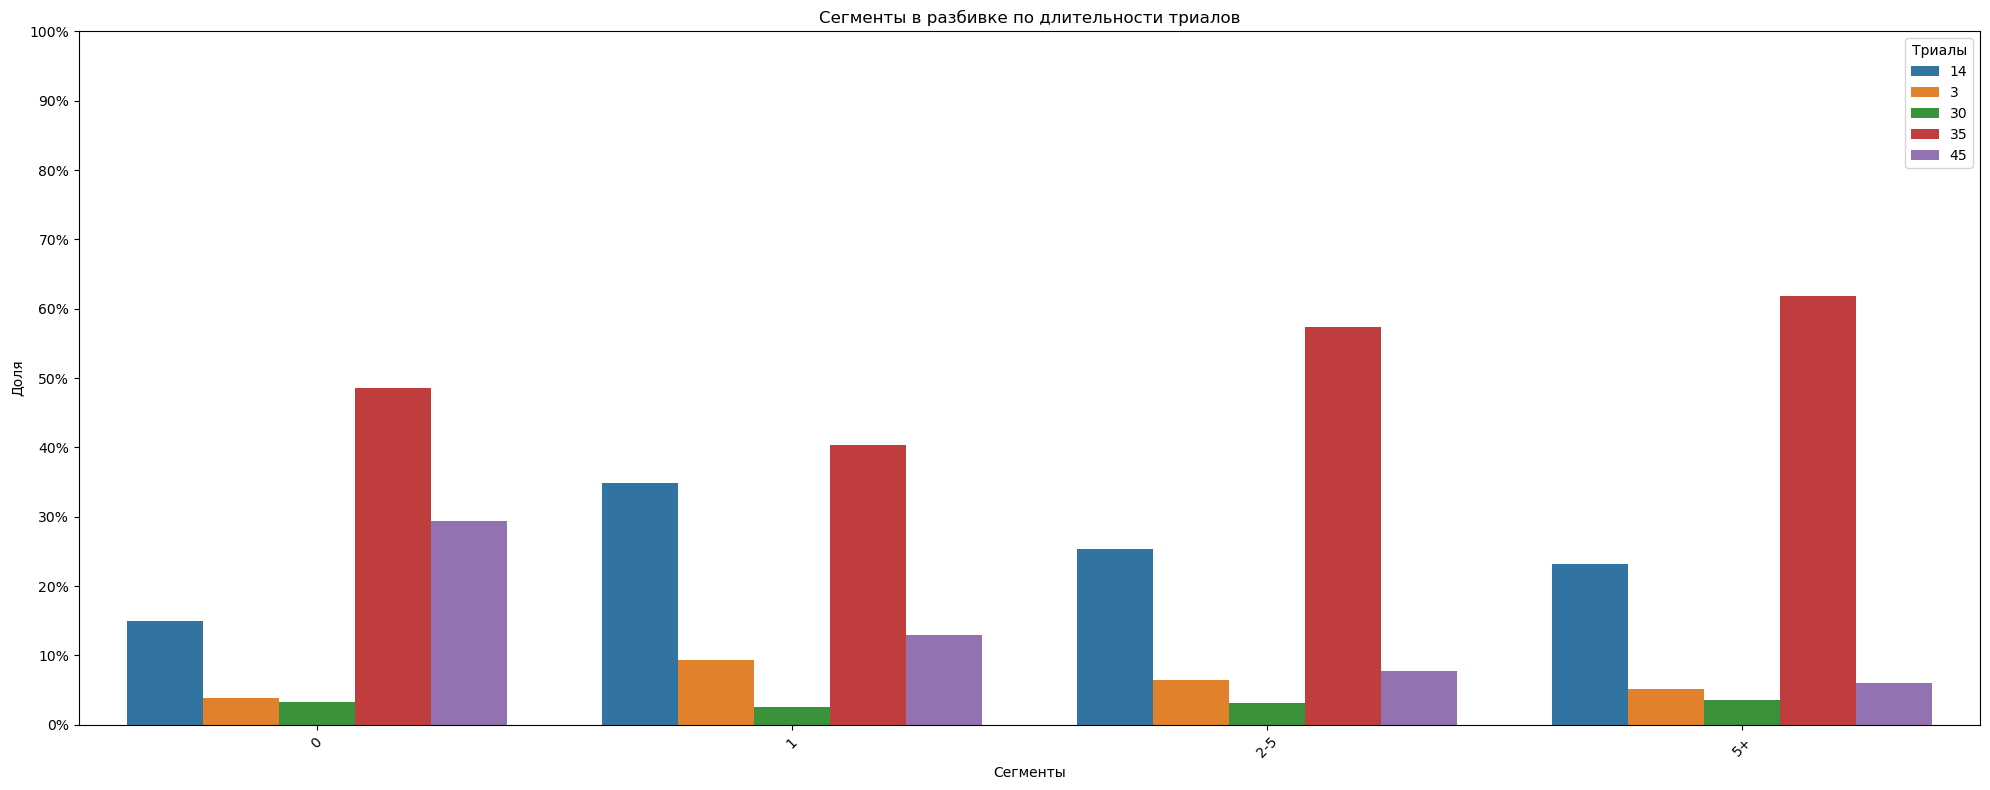

In [246]:
trial_type('segments_watch')

In [252]:
list_date = pd.date_range("2024-04-01", "2024-07-31", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND DATE_TRUNC('month', paid_at::date)='{date_str}'
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                GROUP BY 1,2,3,4,5
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_payment = pd.concat(result)
df_payment['paid_date'] = df_payment['paid_date'].astype('datetime64[ns]')
df_payment['payment'] = df_payment['payment'].astype('int32')

Время выполнения функции: 26.5324 секунд

Дата '2024-04-01' загружена

Время выполнения функции: 14.9872 секунд

Дата '2024-05-01' загружена

Время выполнения функции: 5.0171 секунд

Дата '2024-06-01' загружена

Время выполнения функции: 4.6083 секунд

Дата '2024-07-01' загружена



In [254]:
df_payment.groupby('date_month').agg({'payment':'sum','subscription_id':'nunique'}).reset_index()

,date_month,payment,subscription_id
0,2024-04-01,988639,2787
1,2024-05-01,1074662,2935
2,2024-06-01,1109673,3070
3,2024-07-01,998644,3160


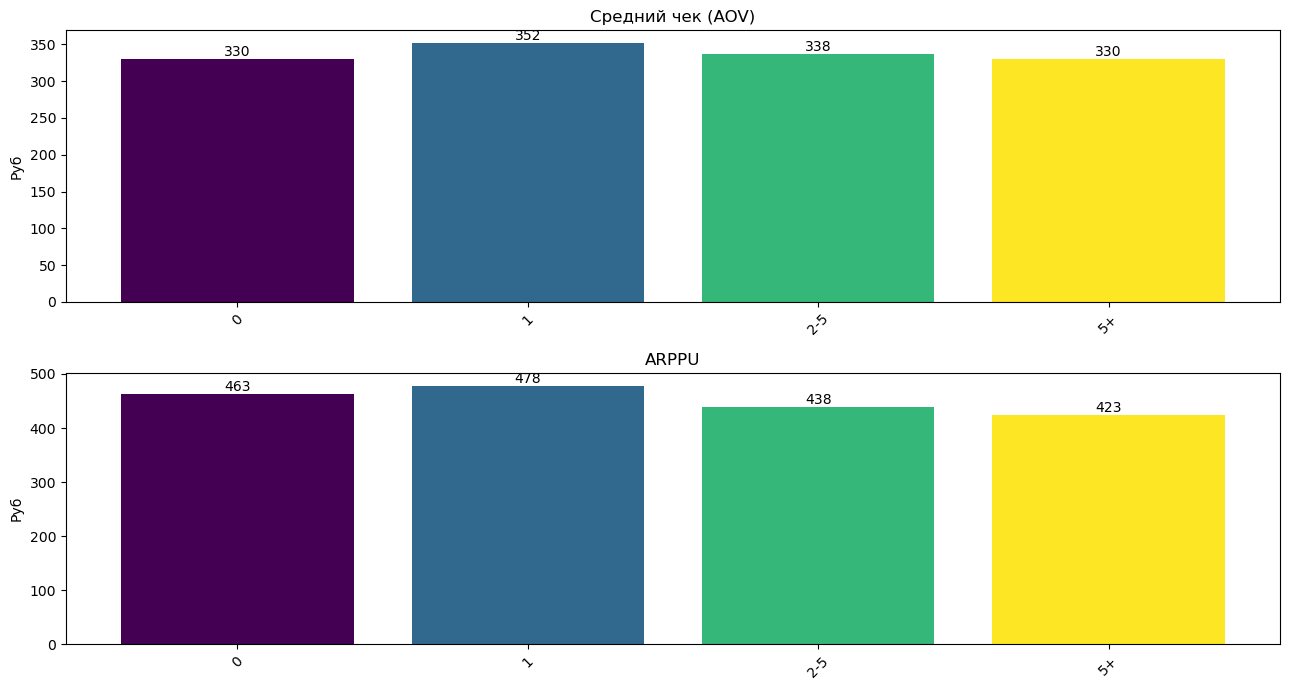

In [379]:
df_payment_agg = df_payment.groupby('user_id').agg({'payment':'sum','subscription_id':'count'}).reset_index()

df_payment2 = pd.merge(df_payment_agg,df_w_new_max[['user_id','segments','segments_watch','created_date']],on='user_id',how='left')
df_pay2 = pd.merge(df_payment,df_w_new_max[['user_id','segments','segments_watch','created_date']],on='user_id',how='inner')


df_payment2_agg_segments = df_payment2[df_payment2.created_date.notna()].groupby('segments').agg({'user_id':'nunique','payment':'sum','subscription_id':'sum'}).reset_index()
df_payment2_agg_segments_watch = df_payment2[df_payment2.created_date.notna()].groupby('segments_watch').agg({'user_id':'nunique','payment':'sum','subscription_id':'sum'}).reset_index()

df_payment2_agg_segments['ARPPU'] = df_payment2_agg_segments.payment / df_payment2_agg_segments.user_id
df_payment2_agg_segments['AOV'] = df_payment2_agg_segments.payment / df_payment2_agg_segments.subscription_id
df_payment2_agg_segments



fig, axs = plt.subplots(2, 1, figsize=(13, 7))  

# Построение первого графика (AOV)  
bar1 = axs[0].bar(df_payment2_agg_segments['segments'], df_payment2_agg_segments['AOV'],  color=plt.cm.viridis(np.linspace(0, 1, len(t1))))  
axs[0].set_title('Средний чек (AOV)')   
axs[0].set_ylabel('Руб')  
axs[0].tick_params(axis='x', rotation=45)  # Вращение меток по оси X для лучшей читаемости  

# Построение второго графика (ARPPU)  
bar2 = axs[1].bar(df_payment2_agg_segments['segments'], df_payment2_agg_segments['ARPPU'],  color=plt.cm.viridis(np.linspace(0, 1, len(t1))))  
axs[1].set_title('ARPPU')   
axs[1].set_ylabel('Руб')  
axs[1].tick_params(axis='x', rotation=45)  # Вращение меток по оси X для лучшей читаемости  

for bar in bar1:  
        yval = bar.get_height()  
        axs[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{int(round(yval))}', ha='center', va='bottom')

for bar in bar2:  
        yval = bar.get_height()  
        axs[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{int(round(yval))}', ha='center', va='bottom')        
            
# Настройка компоновки  
plt.tight_layout()  
plt.show()  

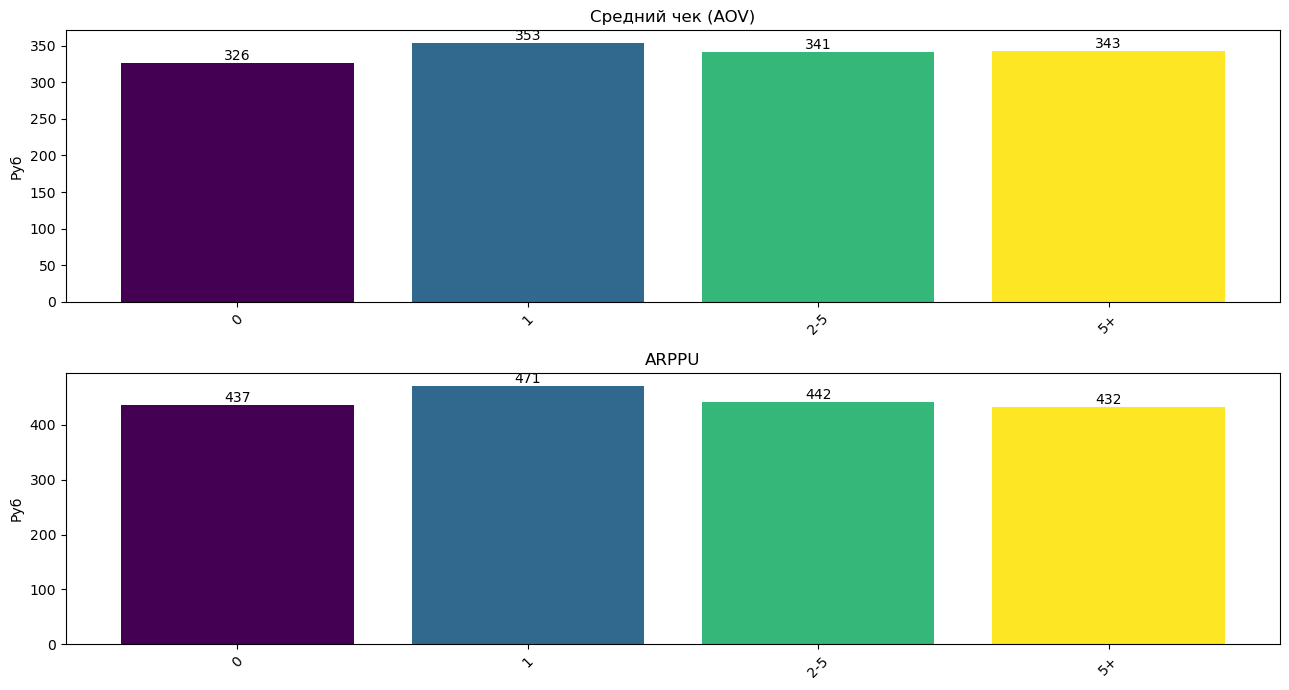

In [381]:
df_payment2_agg_segments_watch['ARPPU'] = df_payment2_agg_segments_watch.payment / df_payment2_agg_segments_watch.user_id
df_payment2_agg_segments_watch['AOV'] = df_payment2_agg_segments_watch.payment / df_payment2_agg_segments_watch.subscription_id


fig, axs = plt.subplots(2, 1, figsize=(13, 7))  

# Построение первого графика (AOV)  
bar1 = axs[0].bar(df_payment2_agg_segments_watch['segments_watch'], df_payment2_agg_segments_watch['AOV'],  color=plt.cm.viridis(np.linspace(0, 1, len(t1))))  
axs[0].set_title('Средний чек (AOV)')   
axs[0].set_ylabel('Руб')  
axs[0].tick_params(axis='x', rotation=45) 

# Построение второго графика (ARPPU)  
bar2 = axs[1].bar(df_payment2_agg_segments_watch['segments_watch'], df_payment2_agg_segments_watch['ARPPU'],  color=plt.cm.viridis(np.linspace(0, 1, len(t1))))  
axs[1].set_title('ARPPU')   
axs[1].set_ylabel('Руб')  
axs[1].tick_params(axis='x', rotation=45)

for bar in bar1:  
        yval = bar.get_height()  
        axs[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{int(round(yval))}', ha='center', va='bottom')

for bar in bar2:  
        yval = bar.get_height()  
        axs[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{int(round(yval))}', ha='center', va='bottom')        
            
# Настройка компоновки  
plt.tight_layout()  
plt.show()

In [339]:
         # Рассчитываем средневзвешенное значение LTV для каждого 'num_of_month'
def calculate_weighted_avg_ltv(df_segment):
    segment_name = df_segment.name
    segment_weighted_ltv = (df_segment * user_counts.loc[(slice(None), segment_name), :]).sum() / user_counts.loc[(slice(None), segment_name), :].sum()
    return segment_weighted_ltv

# Создание данных
def ltv(df_pay2,segment):
    df_pay2['paid_month'] = df_pay2['paid_date'].dt.to_period('M')
    df_pay2 = df_pay2.sort_values(by=[segment,'date_month','paid_month'])
    df_ltv = df_pay2.groupby(['date_month', 'paid_month', segment]).agg({'payment': 'sum', 'user_id': 'count'}).reset_index()

        # Расчет кумулятивной суммы и добавления поля по числу пользователей когорты 
    df_ltv = df_ltv.sort_values(by=['date_month', segment, 'paid_month'])
    df_ltv['cumulative'] = df_ltv.groupby([segment])['payment'].cumsum()
    df_ltv['uniq_user'] = df_ltv.groupby([segment])['user_id'].transform('max')

        # # Расчет ltv
    df_ltv['ltv'] = df_ltv.cumulative / df_ltv.uniq_user

        # # Нумерация месяцев
    df_ltv['num_of_month'] = df_ltv.groupby([segment])['paid_month'].rank(method='first').astype('int')

        # Сделаем pivot
    df_pivot = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')
    df_pivot['uniq_user'] = df_ltv.groupby(['date_month', segment])['uniq_user'].max()

        # Создаем DataFrame с данными для расчета средневзвешенного LTV
    weighted_ltv = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')
    user_counts = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='uniq_user')


    weighted_avg_ltv = weighted_ltv.groupby(level=segment).apply(calculate_weighted_avg_ltv)

        # Преобразуем в DataFrame
    weighted_avg_ltv = weighted_avg_ltv.reset_index()
    weighted_avg_ltv = weighted_avg_ltv.rename(columns={0: 'cumsum'})

        #Сначала преобразуем датафрейм в длинный формат с помощью melt
    melted_df = pd.melt(weighted_avg_ltv, id_vars=[segment], var_name='num_of_month', value_name='value')

        # Теперь преобразуем его в требуемый формат с помощью pivot
    pivot_df = melted_df.pivot(index='num_of_month', columns=segment, values='value').reset_index()
        
        
    plt.figure(figsize=(30,10))

        # Построение линий для каждого сегмента
    for i in pivot_df.columns[1:]:
        plt.plot(pivot_df.num_of_month, pivot_df[i], marker='o', linestyle='-', label=i)

    plt.xlabel('Месяцы')
    plt.ylabel('Руб')
    plt.title('Изменение LTV по месяцам')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title='Segments')
    plt.show()

In [347]:
pivot_df.columns[1:]

Index(['0', '1', '2-5', '5+'], dtype='object', name='segments')

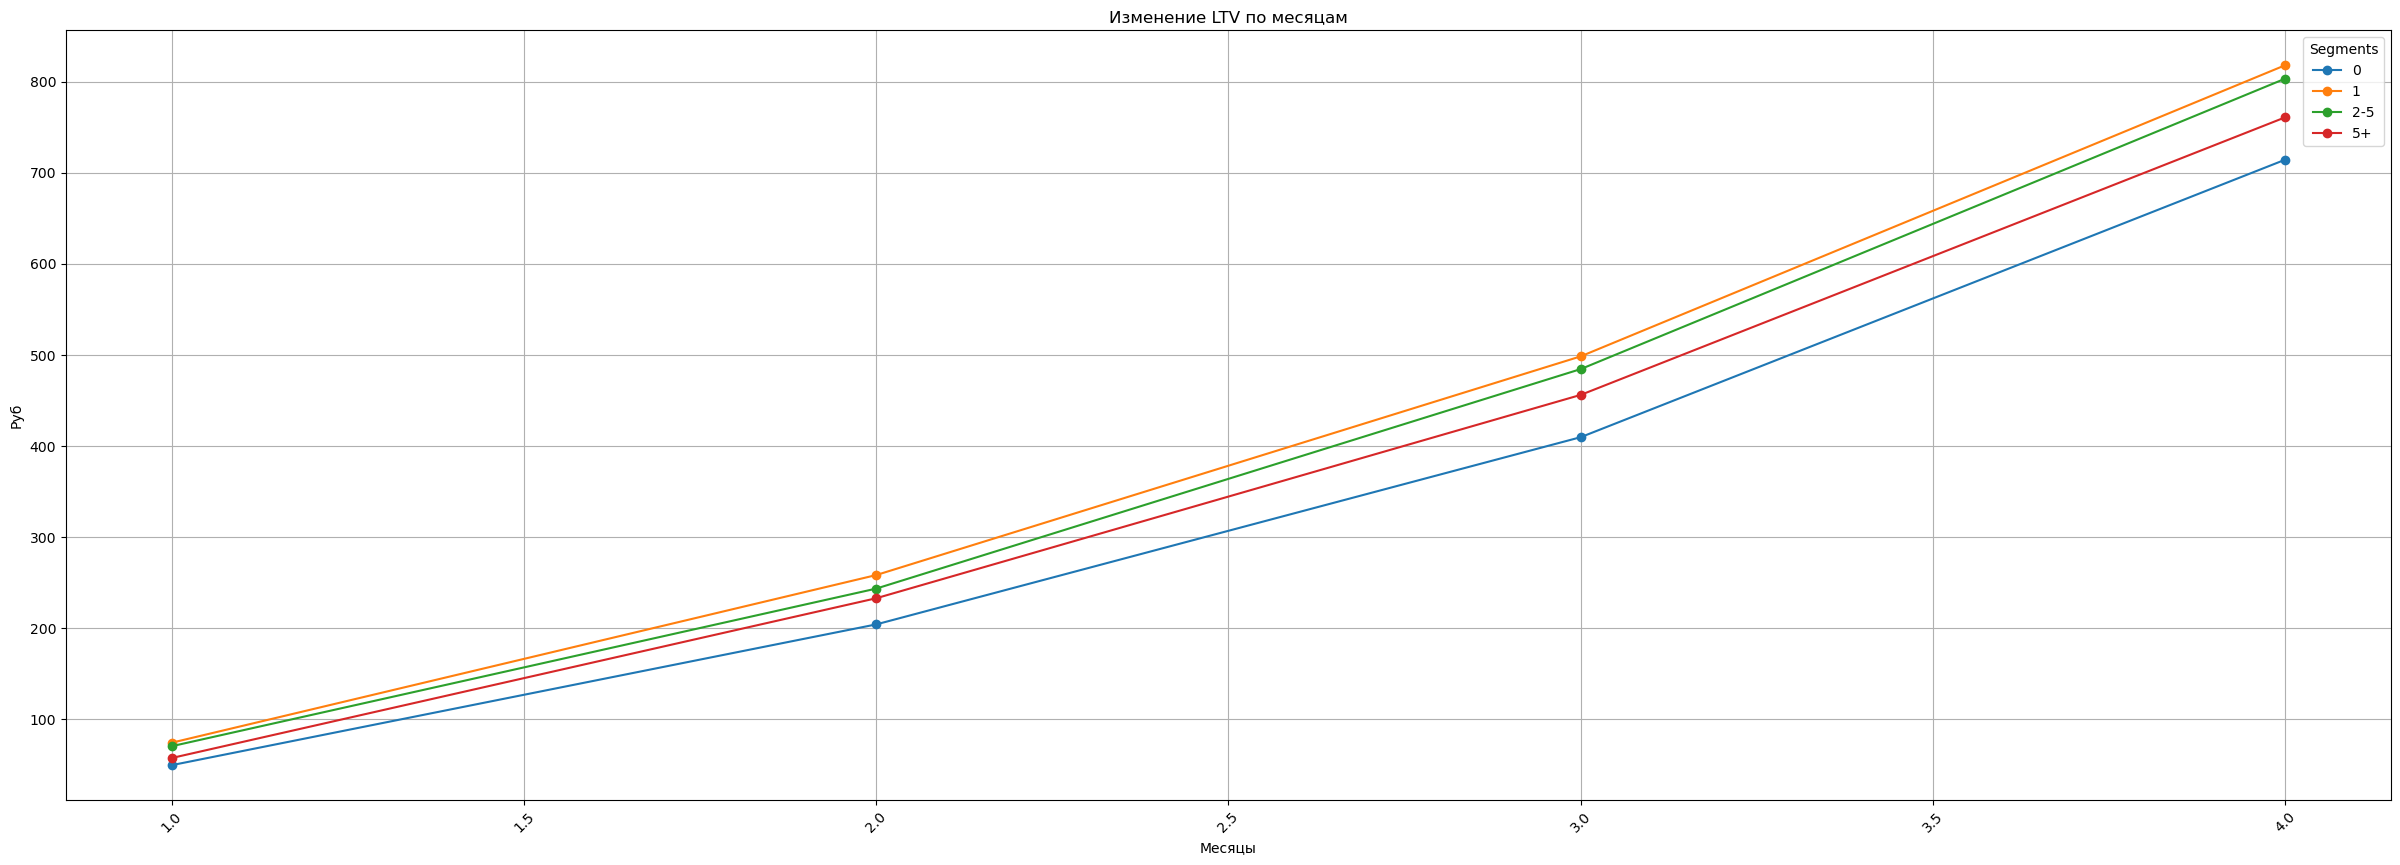

In [717]:
ltv(df_pay2,'segments_watch')

In [400]:
query = """
    SELECT 
        count(DISTINCT CASE WHEN email IS NOT NULL AND phone_number IS NULL THEN profile_id END) cnt_email,
        count(DISTINCT CASE WHEN phone_number IS NOT NULL AND email IS NULL THEN profile_id END) cnt_phone,
        count(DISTINCT CASE WHEN phone_number IS NOT NULL AND email IS NOT NULL THEN profile_id end) cnt_both
        FROM 
        (SELECT t1.profile_id,t2.email,t2.phone_number
        FROM 
        (SELECT DISTINCT profile_id 
        FROM datamarts.mekhtiev_registration_distr
        WHERE created_date::date BETWEEN '2024-04-01' AND '2024-08-01'
        )AS t1

        LEFT JOIN (SELECT profile_id,email,phone_number
                    FROM datamarts.dash_table_distr AS t1
                    LEFT JOIN product_x.users  AS t2
                    ON t1.user_id=t2.id
                    WHERE created_at::date BETWEEN '2024-04-01' AND '2024-08-01'
                    AND email IS NOT NULL OR phone_number IS NOT NULL 
                    GROUP BY 1,2,3
                    ) AS t2
        ON t1.profile_id=t2.profile_id)
        """

df_email = execute(query,user='kmekhtiev')

Время выполнения функции: 3.4799 секунд



## Гипотеза 2 - Посмотреть воронку из регистрации в триал и в подписку среди новых пользователей. Посмотреть доли заходов в приложение через номер/email

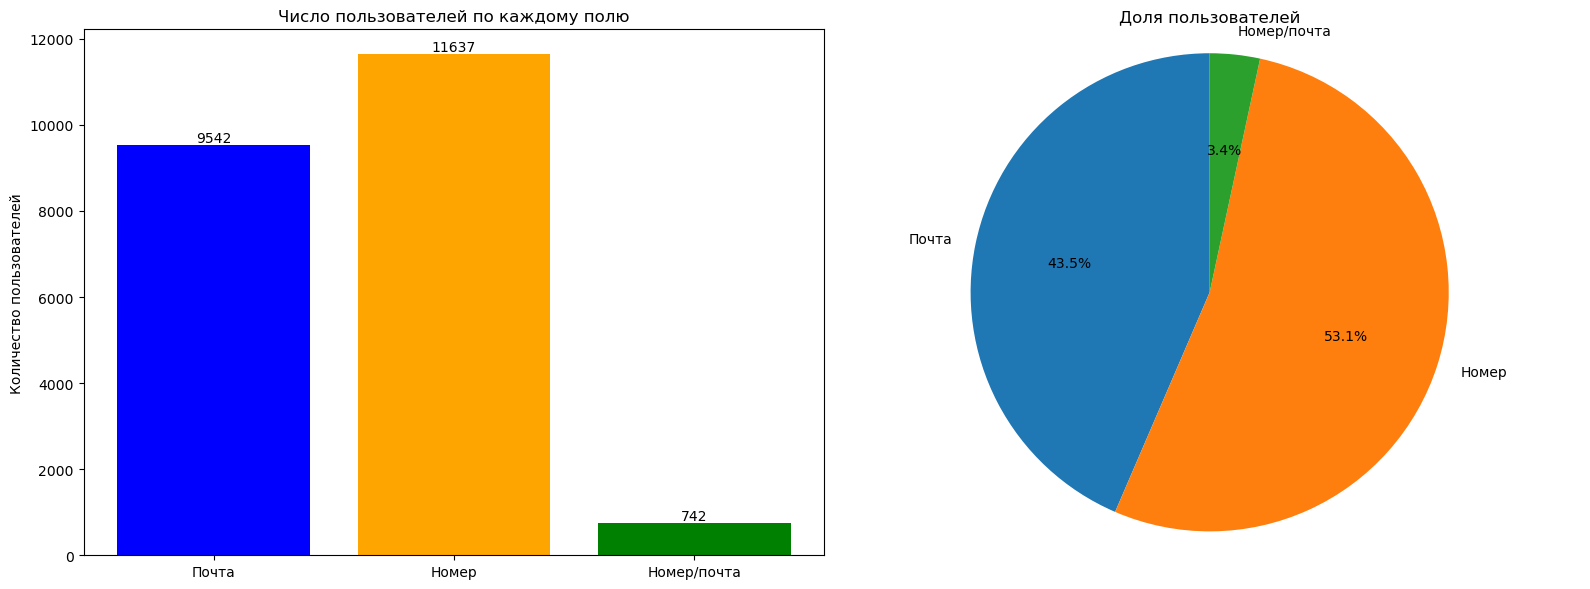

In [416]:
# Подготовка данных для графиков  
labels = ['Почта', 'Номер', 'Номер/почта']  
values = [df_email['cnt_email'][0], df_email['cnt_phone'][0], df_email['cnt_both'][0]]  

# Настройка общего размера графиков  
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  

# Построение столбчатой диаграммы  
bars = axs[0].bar(labels, values, color=['blue', 'orange', 'green'])  
axs[0].set_title('Число пользователей по каждому полю')  
axs[0].set_ylabel('Количество пользователей')  

for bar in bars:  
    yval = bar.get_height()  
    axs[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval),   
                 ha='center', va='bottom')  # 'ha' - горизонтальное выравнивание, 'va' - вертикальное  


# Построение круговой диаграммы  
axs[1].pie(values, labels=labels, autopct='%1.1f%%', startangle=90)  
axs[1].set_title('Доля пользователей')  

# Упорядочивание круговой диаграммы  
axs[1].axis('equal')  # Обеспечить, чтобы круг был кругом  

# Показать графики  
plt.tight_layout()  
plt.show()  

## Гипотеза 3 - сегментировать триал пользователей по смотрению

In [ ]:
query = '''CREATE TABLE datamarts.mekhtiev_watchtime_days_local ON CLUSTER 'viasat_cluster'
            (
                date Date,
                profile_id UUID,
                item_title String,
                item_type String,
                watchtime Int32
             )
             ENGINE = ReplicatedMergeTree('/clickhouse/tables/{shard}/datamarts.mekhtiev_watchtime_days_local', '{replica}')
             ORDER BY date
             '''
execute(query,user = 'kmekhtiev')

query = '''CREATE TABLE datamarts.mekhtiev_watchtime_days_distr ON CLUSTER 'viasat_cluster'
            (
                date Date,
                profile_id UUID,
                item_title String,
                item_type String,
                watchtime Int32
             )
            ENGINE = Distributed(viasat_cluster, datamarts, mekhtiev_watchtime_days_local, rand())
             '''
execute(query,user = 'kmekhtiev')

In [11]:
query_truncate = """TRUNCATE TABLE datamarts.mekhtiev_watchtime_days_local  ON CLUSTER 'viasat_cluster' """
execute(query_truncate,user='kmekhtiev')


query = """ INSERT INTO datamarts.mekhtiev_watchtime_days_distr
                                        SELECT 
                                                date,
                                                profile_id,
                                                item_title,
                                                item_type,
                                                sum(viewing_time) AS watchtime
                                                FROM 
                                                    (SELECT 
                                                                date,
                                                                profile_id,                                                      
                                                                event_page,
                                                            JSONExtractInt(payload,'duration') AS duration,
                                                            JSONExtractString(payload,'item_type') AS item_type,
                                                            JSONExtractString(payload,'item_title') AS item_title,
                                                            CASE WHEN event_page<>'tvchannel'
                                                                      AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration') 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                                 WHEN event_page='tvchannel' 
                                                                      AND JSONExtractInt(payload,'viewing_time') <18000 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                            END AS viewing_time                                
                                                            FROM datamarts.sandbox_data_distr AS t1
                                                            LEFT JOIN product_x.users AS u ON t1.user_id=u.id
                                                            WHERE date BETWEEN '2024-04-01'  AND '2024-08-15'
                                                            AND event_name IN ('auto_player_streaming','auto_kinom_streaming')
                                                            AND viewing_time IS NOT NULL   
                                                            AND (promo_type IS NULL OR promo_type!='cards')
                                                            AND (u.email NOT LIKE '%@test%' OR u.email IS NULL)
                                                            AND created_at>='2024-04-01'
                                                            and reg_date>='2024-04-01'
                                                          )
                                                          GROUP BY 1,2,3,4
"""
execute(query,user='kmekhtiev')

Время выполнения функции: 0.7216 секунд

Время выполнения функции: 49.0 секунд



""


In [207]:
query = '''CREATE TABLE datamarts.mekhtiev_trial_user_local ON CLUSTER 'viasat_cluster'
            (
                profile_id UUID,
                reg_date Date,
                trial_start Date,
                trial_end Date,
                first_prolong_date Date,
                free_days Int32,
                promo_type String,
                subs_type Int32
             )
             ENGINE = ReplicatedMergeTree('/clickhouse/tables/{shard}/datamarts.mekhtiev_trial_user_local', '{replica}')
             ORDER BY reg_date
             '''
execute(query,user = 'kmekhtiev')



query = '''CREATE TABLE datamarts.mekhtiev_trial_user_distr ON CLUSTER 'viasat_cluster'
            (
                profile_id UUID,
                reg_date Date,
                trial_start Date,
                trial_end Date,
                first_prolong_date Date,
                free_days Int32,
                promo_type String,
                subs_type Int32
             )
            ENGINE = Distributed(viasat_cluster, datamarts, mekhtiev_trial_user_local, rand())
             '''
execute(query,user = 'kmekhtiev')

Время выполнения функции: 1.7001 секунд

Время выполнения функции: 0.4017 секунд



,host,port,status,error,num_hosts_remaining,num_hosts_active
0,dwh02,9000,0,,3,0
1,dwh03,9000,0,,2,0
2,dwh01,9000,0,,1,0
3,dwh04,9000,0,,0,0


In [209]:
query_truncate = """TRUNCATE TABLE datamarts.mekhtiev_trial_user_distr  ON CLUSTER 'viasat_cluster' """
execute(query_truncate,user='kmekhtiev')

query = """ INSERT INTO datamarts.mekhtiev_trial_user_distr
                SELECT
                    profile_id,
                    reg_date,
                    created_at::date AS trial_start,
                    trial_start + free_days AS trial_end,
                    first_prolong_date,
                    free_days,
                    promo_type,
                    CASE WHEN first_prolong_date='1970-01-01' THEN 0 ELSE 1 END AS subs_type
                    FROM datamarts.marketing_dash_distr AS t1
                    LEFT JOIN product_x.users AS u ON t1.user_id=u.id
                    WHERE created_at>='2024-04-01' 
                    AND reg_date>='2024-04-01'
                    AND free_days IN (3,14,30,35,45)
                    AND (promo_type IS NULL OR promo_type!='cards')
                    AND (u.email NOT LIKE '%@test%' OR u.email IS NULL)
"""
execute(query,user='kmekhtiev')

Время выполнения функции: 1.4863 секунд

Время выполнения функции: 2.1308 секунд



""


In [349]:
df_watchtime = execute(""" SELECT * FROM datamarts.mekhtiev_watchtime_days_distr""",user='kmekhtiev')
df_trial_user = execute(""" SELECT * FROM datamarts.mekhtiev_trial_user_distr WHERE reg_date>='2024-01-01' AND profile_id<>'00000000-0000-0000-0000-000000000000' """,user='kmekhtiev')

df_merge = (pd.merge(df_trial_user[['profile_id','free_days','trial_start','trial_end','subs_type','promo_type']]
                     ,df_watchtime[['date','profile_id','watchtime','item_title','item_type']]
                     ,how='left'
                     ,on='profile_id'
                     ,indicator = 'profile_type')
           )
df_merge['watchtime'].fillna(0,inplace=True)
df_merge['item_title'].fillna('No_one',inplace=True)
df_merge['item_type'].fillna('No_one',inplace=True)
df_merge['profile_type'] = df_merge['profile_type'].astype(str)
df_merge['trial_start'] = df_merge['trial_start'].astype('datetime64[ns]')
df_merge_agg = (df_merge[(((df_merge.date <= df_merge.trial_end) & (df_merge.date >= df_merge.trial_start)) | (df_merge.date.isna())) & (df_merge.watchtime>=0) & (df_merge.item_type.isin(['series','movie','No_one']))]
                .groupby(['profile_id','free_days','trial_start','trial_end','subs_type','promo_type','profile_type'])
                .agg({'watchtime':'sum','item_title':'nunique'})
                .reset_index()
               )
df_merge_agg['watchtime']=df_merge_agg.watchtime/60

Время выполнения функции: 2.4193 секунд

Время выполнения функции: 0.576 секунд



<Axes: >

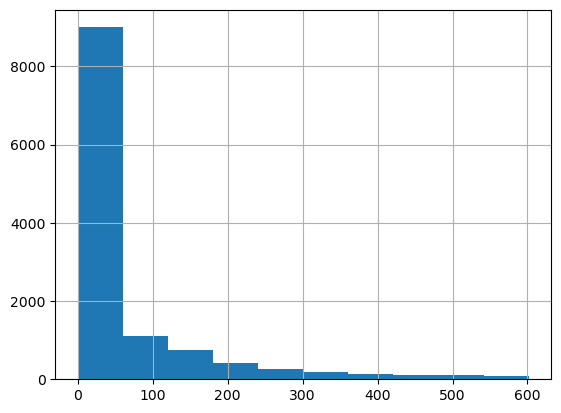

In [350]:
df_merge_agg[df_merge_agg.watchtime<np.percentile(df_merge_agg['watchtime'],95)]['watchtime'].hist()

In [351]:
conditions = [  
    (df_merge_agg['profile_type'] == 'left_only') & (df_merge_agg['item_title'] == 1),  
    (df_merge_agg['profile_type'] == 'both') & (df_merge_agg['item_title'] == 1),  
    (df_merge_agg['profile_type'] == 'both') & (df_merge_agg['item_title'] > 1) & (df_merge_agg['item_title'] <= 5),  
    (df_merge_agg['profile_type'] == 'both') & (df_merge_agg['item_title'] > 5)
    ]  
# Определяем соответствующие значения для каждого условия  
choices = ['0', '1', '2-5', '5+']  
# Применяем np.select для создания новом столбца  
df_merge_agg['segments'] = np.select(conditions, choices, default='unknown')  

In [352]:
conditions = [  
    (df_merge_agg['free_days'] == 3) & (df_merge_agg['trial_start']>='2024-08-15'),  
    (df_merge_agg['free_days'] == 14) & (df_merge_agg['trial_start']>='2024-08-04'),  
    (df_merge_agg['free_days'] == 30) & (df_merge_agg['trial_start']>='2024-07-26'),  
    (df_merge_agg['free_days'] == 35) & (df_merge_agg['trial_start']>='2024-07-21'),
    (df_merge_agg['free_days'] == 45) & (df_merge_agg['trial_start']>='2024-07-11')
    ]  
# Определяем соответствующие значения для каждого условия  
choices = [1, 1, 1, 1, 1]  
# Применяем np.select для создания новом столбца  
df_merge_agg['user_type'] = np.select(conditions, choices, default=0)  

In [357]:
df_merge_agg = df_merge_agg[df_merge_agg['user_type']==0]

In [359]:
df_merge_agg.groupby(['segments'])['profile_id'].count().reset_index()

,segments,profile_id
0,0,4213
1,1,4093
2,2-5,1862
3,5+,474


In [361]:
t3 = df_merge_agg.groupby(['segments','subs_type','promo_type'])['profile_id'].nunique().reset_index()
t3.rename(columns={'profile_id': 'cnt_trial'}, inplace=True)
t3['trial_frac'] = t3.cnt_trial/t3.groupby('segments')['cnt_trial'].transform('sum')
t3

,segments,subs_type,promo_type,cnt_trial,trial_frac
0,0,0,no_promo,600,0.142416
1,0,0,promo,3012,0.714930
2,0,1,no_promo,203,0.048184
3,0,1,promo,398,0.094469
4,1,0,no_promo,1718,0.419741
5,1,0,promo,1453,0.354996
6,1,1,no_promo,613,0.149768
7,1,1,promo,309,0.075495
8,2-5,0,no_promo,489,0.262621
9,2-5,0,promo,888,0.476907


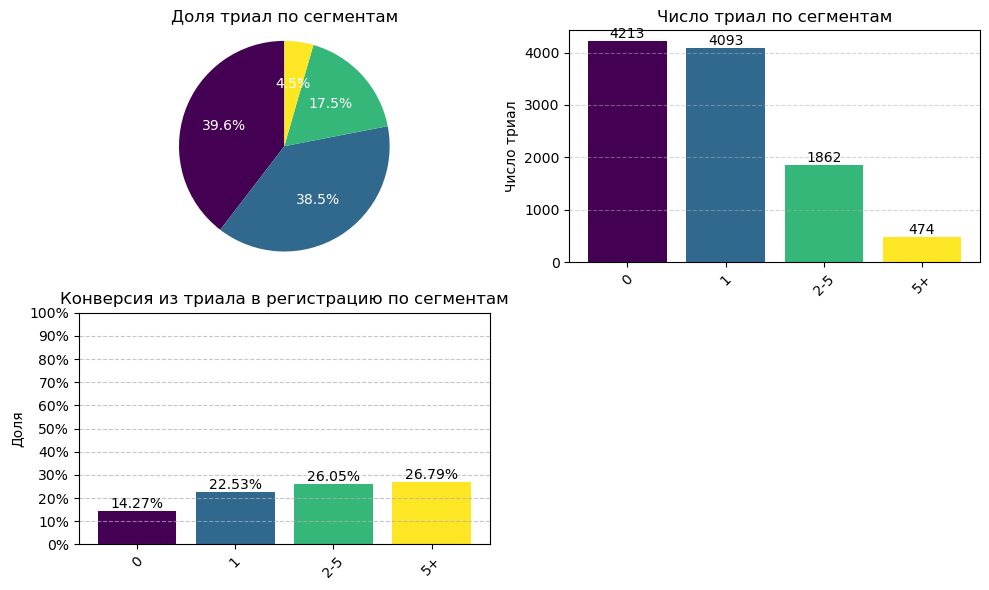

In [615]:


t1 = df_merge_agg.groupby(['segments'])['profile_id'].nunique().reset_index()
t1.rename(columns={'profile_id': 'cnt_trial'}, inplace=True)
t1['frac_trial'] = t1.cnt_trial / t1.cnt_trial.sum()
    
t2 = df_merge_agg[(df_merge_agg.subs_type==1)].groupby(['segments'])['profile_id'].nunique().reset_index()
t2.rename(columns={'profile_id': 'cnt_subs'}, inplace=True)
t1 = pd.merge(t1, t2, how='left', on='segments')
t1['trial_to_subs'] = t1.cnt_subs / t1.cnt_trial  





# Создание графиков в виде подграфиков
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

labels = t1['segments'] 
values = [t1['cnt_trial'][0], t1['cnt_trial'][1], t1['cnt_trial'][2],t1['cnt_trial'][3]]
     
axs[0,0].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(t1))),textprops={'color':'white'})  
axs[0,0].set_title('Доля триал по сегментам')  
axs[0,0].axis('equal')  # Обеспечить, чтобы круг был кругом  

bars2 = axs[0,1].bar(t1['segments'], t1['cnt_trial'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
axs[0,1].set_title('Число триал по сегментам')
axs[0,1].set_ylabel('Число триал')
axs[0,1].set_xticklabels(t1['segments'], rotation=45)
axs[0,1].grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars2:
    yval = bar.get_height()
    axs[0,1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')


values2 = [t1['frac_trial'][0], t1['frac_trial'][1], t1['frac_trial'][2],t1['frac_trial'][3]]
bars5 = axs[1,0].bar(t1['segments'], t1['trial_to_subs'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
axs[1,0].set_title('Конверсия из триала в регистрацию по сегментам')
axs[1,0].set_ylabel('Доля')
axs[1,0].set_xticklabels(t1['segments'], rotation=45)
axs[1,0].set_yticks(np.arange(0, 1.1, 0.1))
axs[1,0].set_yticklabels([f'{int(i * 100)}%' for i in np.arange(0, 1.1, 0.1)])
axs[1,0].grid(axis='y', linestyle='--', alpha=0.7)

axs[1, 1].remove()

for bar in bars5:
    yval = bar.get_height()
    axs[1,0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom')
  

plt.tight_layout()
plt.show()


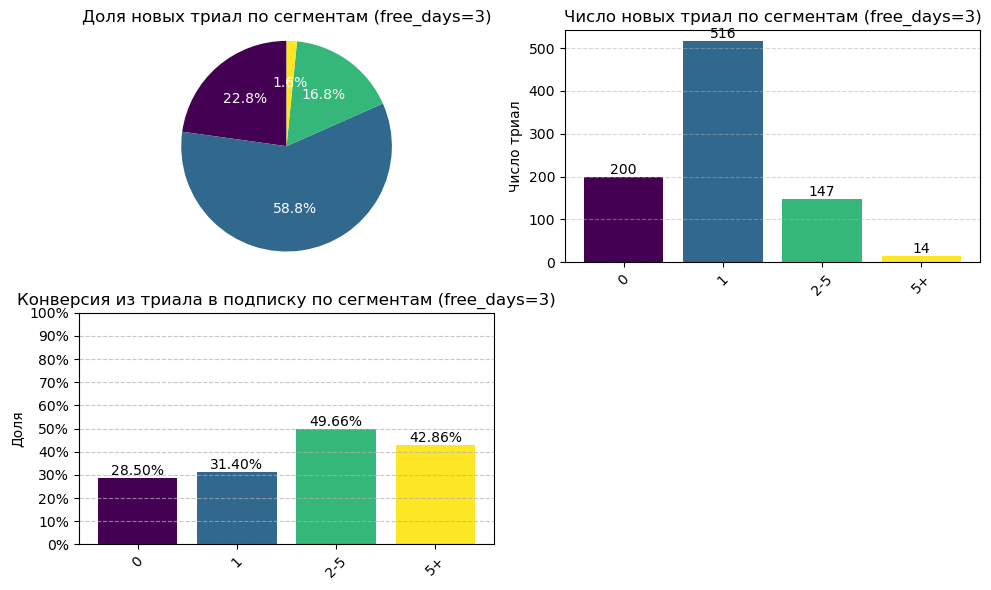

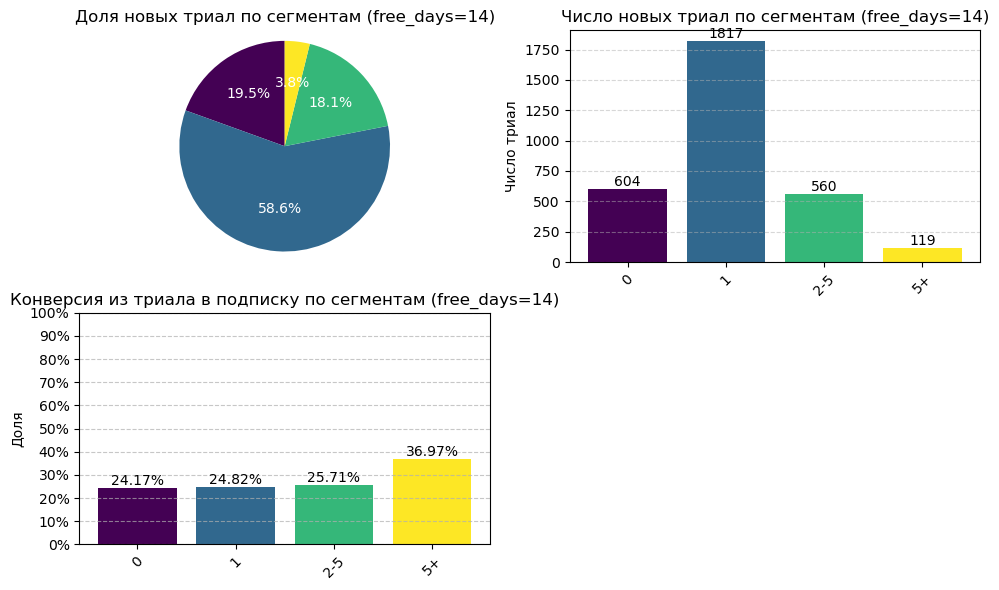

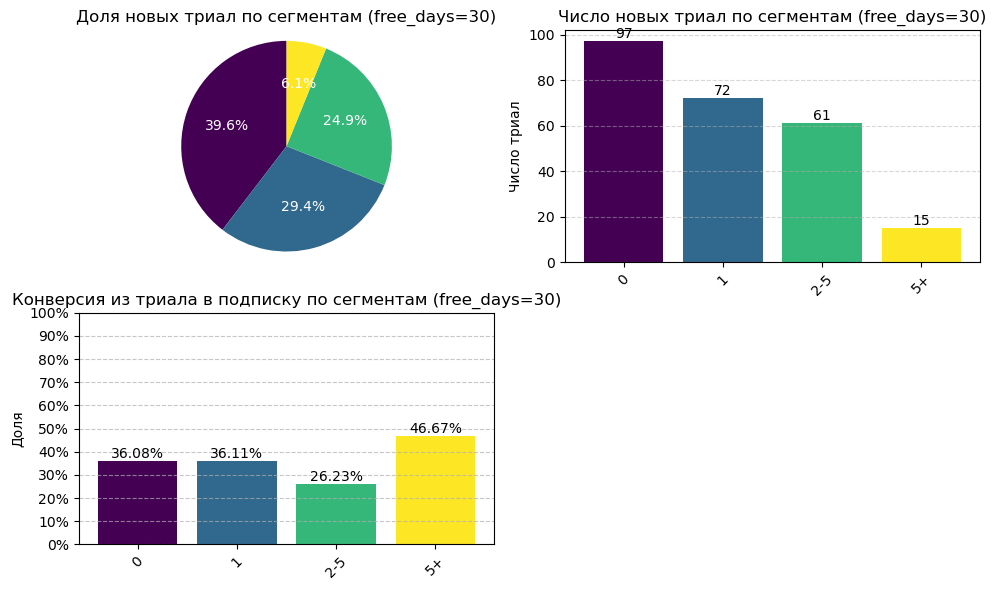

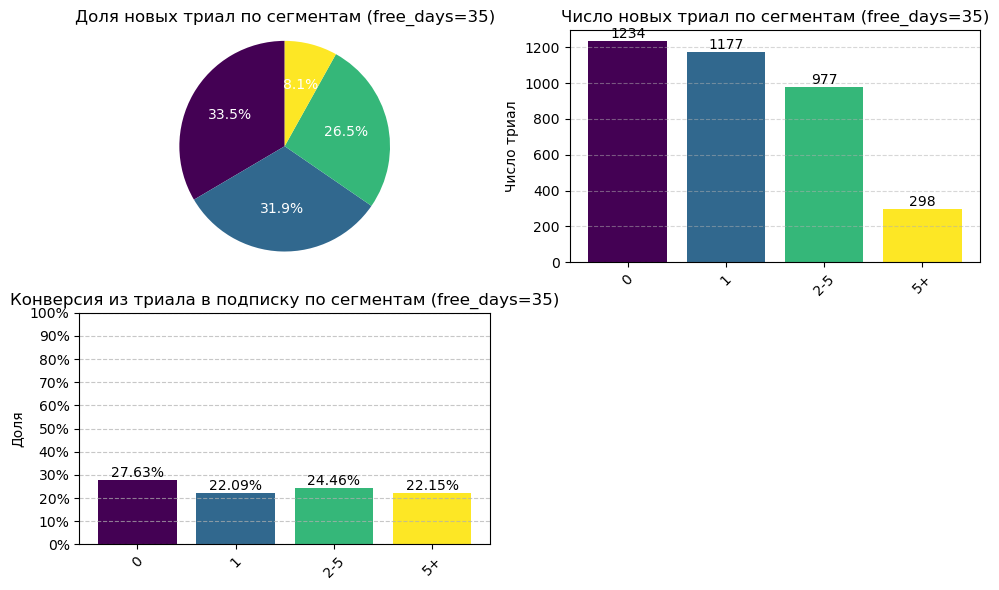

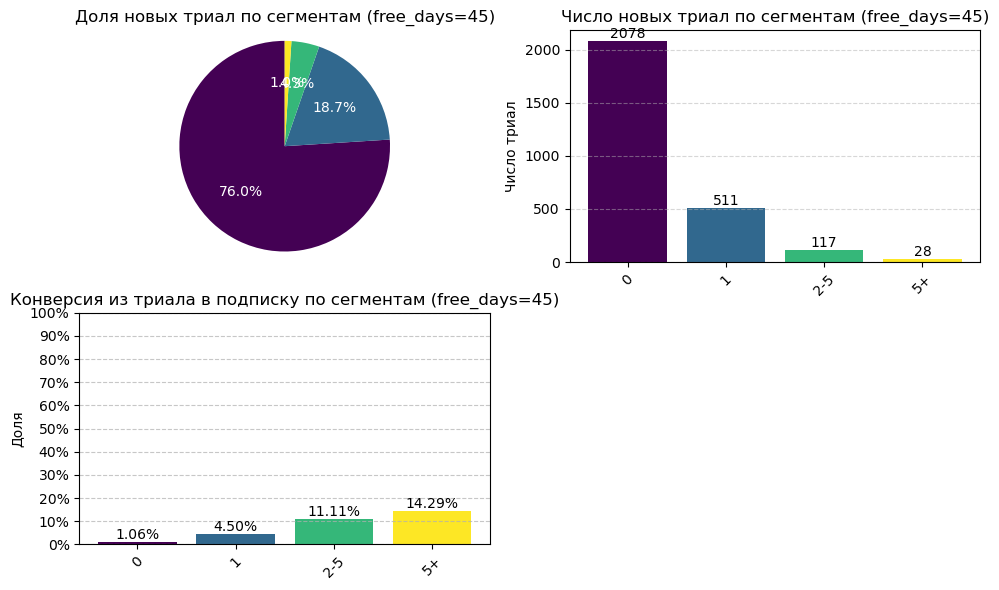

In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Список значений free_days
free_days_values = [3, 14, 30, 35, 45]

# Создание подграфиков для каждого значения free_days
for free_day in free_days_values:
    # Фильтрация данных по текущему значению free_days
    t1 = df_merge_agg[df_merge_agg.free_days == free_day].groupby(['segments'])['profile_id'].nunique().reset_index()
    t1.rename(columns={'profile_id': 'cnt_trial'}, inplace=True)
    t1['frac_trial'] = t1.cnt_trial / t1.cnt_trial.sum()

    t2 = df_merge_agg[(df_merge_agg.subs_type == 1) & (df_merge_agg.free_days == free_day)].groupby(['segments'])['profile_id'].nunique().reset_index()
    t2.rename(columns={'profile_id': 'cnt_subs'}, inplace=True)
    t1 = pd.merge(t1, t2, how='left', on='segments')
    t1['trial_to_subs'] = t1.cnt_subs / t1.cnt_trial

    # Создание графиков в виде подграфиков
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    labels = t1['segments']
    values = t1['cnt_trial']

    axs[0, 0].pie(values, labels=labels, autopct='%1.1f%%', startangle=90,
                  colors=plt.cm.viridis(np.linspace(0, 1, len(t1))),
                  textprops={'color': 'white'})
    axs[0, 0].set_title(f'Доля новых триал по сегментам (free_days={free_day})')
    axs[0, 0].axis('equal')  # Обеспечить, чтобы круг был кругом

    bars2 = axs[0, 1].bar(t1['segments'], t1['cnt_trial'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
    axs[0, 1].set_title(f'Число новых триал по сегментам (free_days={free_day})')
    axs[0, 1].set_ylabel('Число триал')
    axs[0, 1].set_xticklabels(t1['segments'], rotation=45)
    axs[0, 1].grid(axis='y', linestyle='--', alpha=0.5)

    for bar in bars2:
        yval = bar.get_height()
        axs[0, 1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', ha='center', va='bottom')

    bars5 = axs[1, 0].bar(t1['segments'], t1['trial_to_subs'], color=plt.cm.viridis(np.linspace(0, 1, len(t1))))
    axs[1, 0].set_title(f'Конверсия из триала в подписку по сегментам (free_days={free_day})')
    axs[1, 0].set_ylabel('Доля')
    axs[1, 0].set_xticklabels(t1['segments'], rotation=45)
    axs[1, 0].set_yticks(np.arange(0, 1.1, 0.1))
    axs[1, 0].set_yticklabels([f'{int(i * 100)}%' for i in np.arange(0, 1.1, 0.1)])
    axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    axs[1, 1].remove()

    for bar in bars5:
        yval = bar.get_height()
        axs[1, 0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2%}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


In [512]:
list_date = pd.date_range("2024-04-01", "2024-07-31", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND DATE_TRUNC('month', paid_at::date)='{date_str}'
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                GROUP BY 1,2,3,4,5
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_payment = pd.concat(result)
df_payment['paid_date'] = df_payment['paid_date'].astype('datetime64[ns]')
df_payment['payment'] = df_payment['payment'].astype('int32')

Время выполнения функции: 5.5585 секунд

Дата '2024-04-01' загружена

Время выполнения функции: 5.1639 секунд

Дата '2024-05-01' загружена

Время выполнения функции: 5.0818 секунд

Дата '2024-06-01' загружена

Время выполнения функции: 6.3328 секунд

Дата '2024-07-01' загружена



In [366]:
query = """ SELECT * FROM datamarts.marketing_dash_distr WHERE reg_date>='2024-04-01' """
df_user_id = execute(query,user='kmekhtiev')
df_merge_agg = pd.merge(df_merge_agg,df_user_id[['profile_id','user_id']],how='inner',on='profile_id')

Время выполнения функции: 3.5532 секунд



In [371]:
df_pay = pd.merge(df_payment,df_merge_agg[['user_id','segments','trial_start']],on='user_id',how='inner')
df_pay

,date_month,paid_date,user_id,subscription_id,created_date,payment,segments,trial_start
0,2024-04-01,2024-04-21,d9880e81-ea50-4891-b53c-688c971d650e,92fbfc03-c7cb-4976-8924-969697e23948,2024-04-07,299,1,2024-04-07
1,2024-05-01,2024-05-21,d9880e81-ea50-4891-b53c-688c971d650e,92fbfc03-c7cb-4976-8924-969697e23948,2024-04-07,299,1,2024-04-07
2,2024-06-01,2024-06-21,d9880e81-ea50-4891-b53c-688c971d650e,92fbfc03-c7cb-4976-8924-969697e23948,2024-04-07,299,1,2024-04-07
3,2024-07-01,2024-07-21,d9880e81-ea50-4891-b53c-688c971d650e,92fbfc03-c7cb-4976-8924-969697e23948,2024-04-07,299,1,2024-04-07
4,2024-04-01,2024-04-20,33661e97-ce39-45c4-a42a-910d3b0bac0d,4d0d9ba1-5556-4a67-a21e-8e8727f6cb6b,2024-04-06,149,1,2024-04-06
...,...,...,...,...,...,...,...,...
2420,2024-07-01,2024-07-30,61c85e87-bed2-4325-a05f-7107ddccf0dd,16508218-2090-46e3-9da3-a33eb74ff996,2024-06-30,299,2-5,2024-06-30
2421,2024-07-01,2024-07-18,c89073f5-2386-4791-aebf-5d1862dd2696,55975e9c-8ea9-47c3-a832-1170380b2b5d,2024-07-05,299,2-5,2024-07-05
2422,2024-07-01,2024-07-14,c786f144-5a55-4d3f-8c87-3ac5ddff026c,b05bbf9d-0d24-44af-ae1a-b356e0730c9b,2024-07-01,299,1,2024-07-01
2423,2024-07-01,2024-07-03,30bd4b69-609c-4b1a-9a0a-686786ade6d4,1de8b993-51dc-44c3-a39e-ef7f39cc1642,2024-06-19,299,0,2024-06-19


In [385]:
def calculate_weighted_avg_ltv(df_segment, user_counts):  
    segment_name = df_segment.name  
    segment_weighted_ltv = (df_segment * user_counts.loc[(slice(None), segment_name), :]).sum() / user_counts.loc[(slice(None), segment_name), :].sum()  
    return segment_weighted_ltv  


def ltv(df_pay, segment):  
    df_pay['paid_month'] = df_pay['paid_date'].dt.to_period('M')  
    df_pay = df_pay.sort_values(by=[segment, 'date_month', 'paid_month'])  
    df_ltv = df_pay.groupby(['date_month', 'paid_month', segment]).agg({'payment': 'sum', 'user_id': 'count'}).reset_index()  

    # Расчет кумулятивной суммы и добавление поля по числу пользователей когорты   
    df_ltv = df_ltv.sort_values(by=['date_month', segment, 'paid_month'])  
    df_ltv['cumulative'] = df_ltv.groupby([segment])['payment'].cumsum()  
    df_ltv['uniq_user'] = df_ltv.groupby([segment])['user_id'].transform('max')  

    # Расчет LTV  
    df_ltv['ltv'] = df_ltv.cumulative / df_ltv.uniq_user  

    # Нумерация месяцев  
    df_ltv['num_of_month'] = df_ltv.groupby([segment])['paid_month'].rank(method='first').astype('int')  

    # Сделаем pivot  
    df_pivot = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')  
    df_pivot['uniq_user'] = df_ltv.groupby(['date_month', segment])['uniq_user'].max()  

    # Создаем DataFrame с данными для расчета средневзвешенного LTV  
    weighted_ltv = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')  
    user_counts = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='uniq_user')  

    weighted_avg_ltv = weighted_ltv.groupby(level=segment).apply(calculate_weighted_avg_ltv, user_counts=user_counts)  

    # Преобразуем в DataFrame  
    weighted_avg_ltv = weighted_avg_ltv.reset_index()  
    weighted_avg_ltv = weighted_avg_ltv.rename(columns={0: 'cumsum'})  

    # Преобразуем датафрейм в длинный формат с помощью melt  
    melted_df = pd.melt(weighted_avg_ltv, id_vars=[segment], var_name='num_of_month', value_name='value')  

    # Преобразуем в требуемый формат с помощью pivot  
    pivot_df = melted_df.pivot(index='num_of_month', columns=segment, values='value').reset_index()  

    plt.figure(figsize=(30, 10))  

    # Построение линий для каждого сегмента  
    for i in pivot_df.columns[1:]:  
        plt.plot(pivot_df.num_of_month, pivot_df[i], marker='o', linestyle='-', label=i)  

    plt.xlabel('Месяцы')  
    plt.ylabel('Руб')  
    plt.title('Изменение LTV по месяцам')  
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.legend(title='Segments')  
    plt.show()

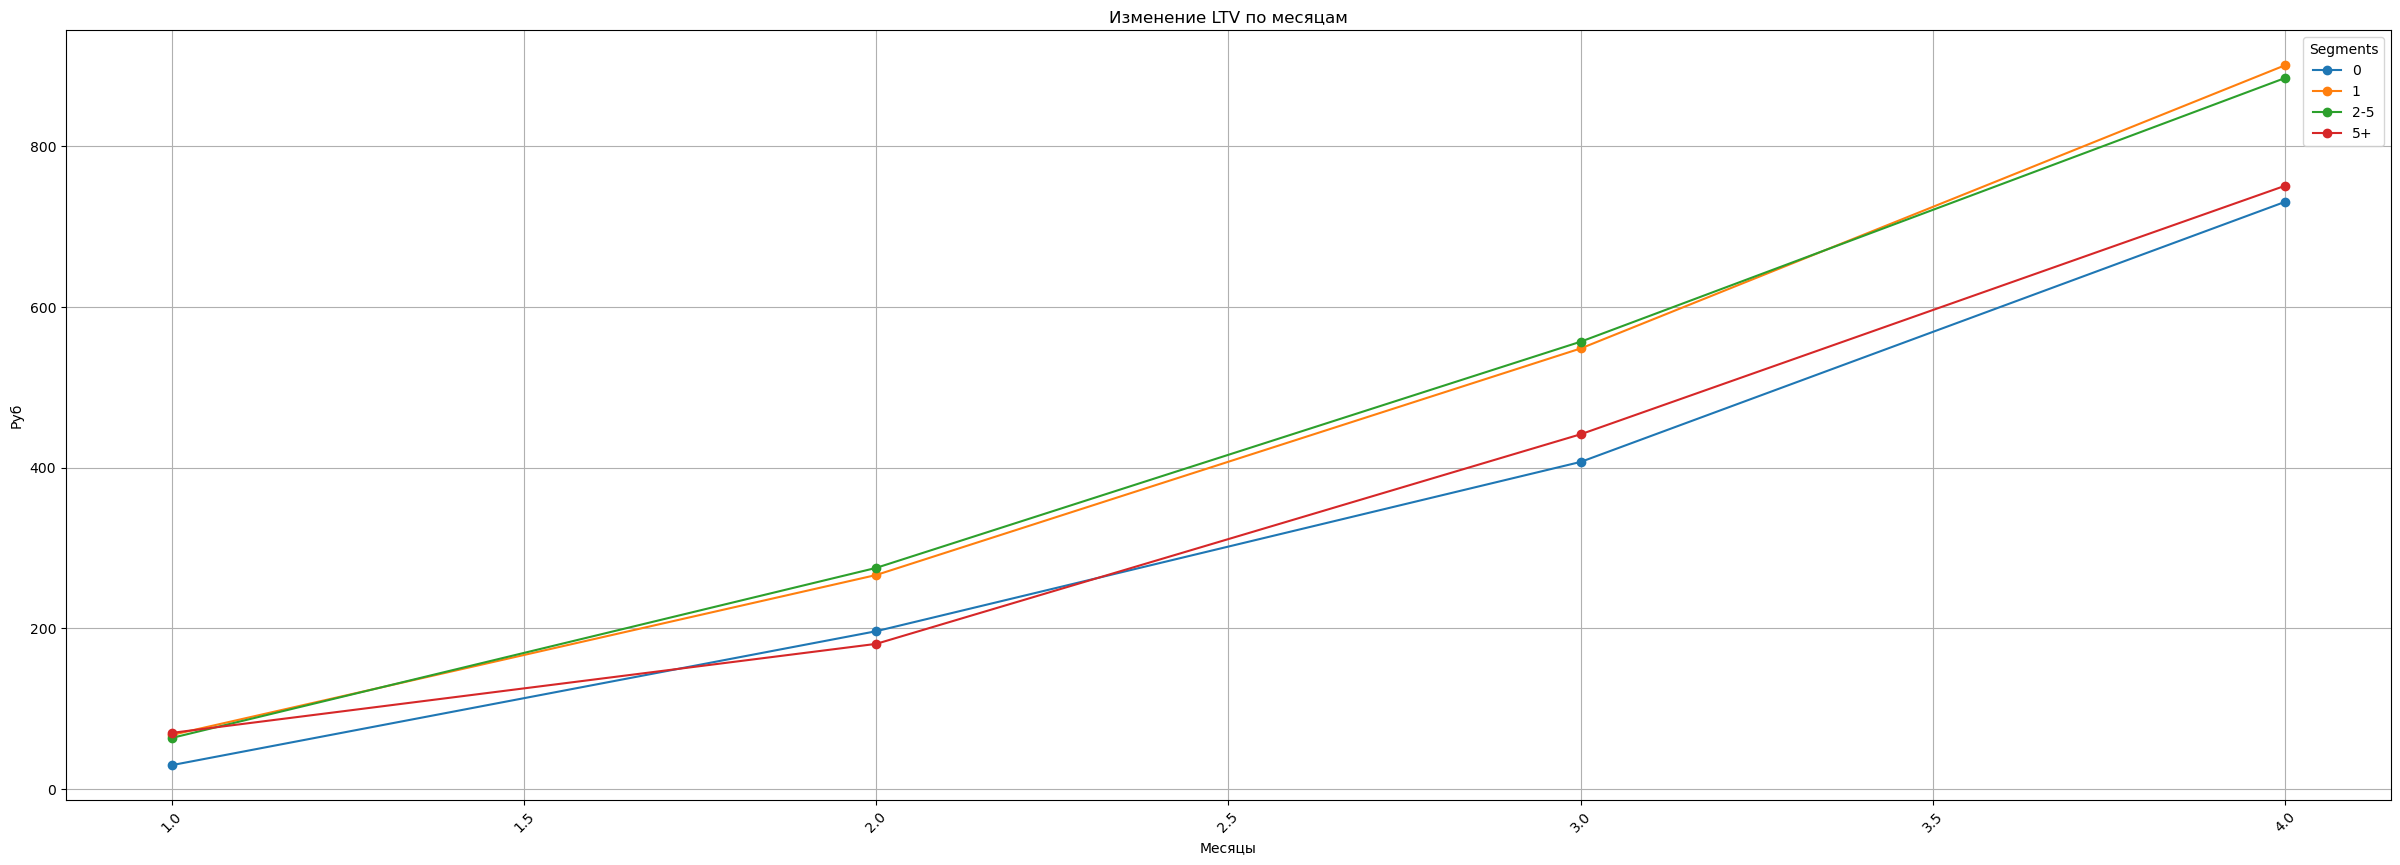

In [387]:
ltv(df_pay,'segments')

In [458]:
query = """SELECT * FROM datamarts.mekhtiev_watchtime_distr2"""
df = execute(query,user='kmekhtiev')
df['date_week'] = df['date_week'].astype('datetime64[ns]')

Время выполнения функции: 5.6824 секунд



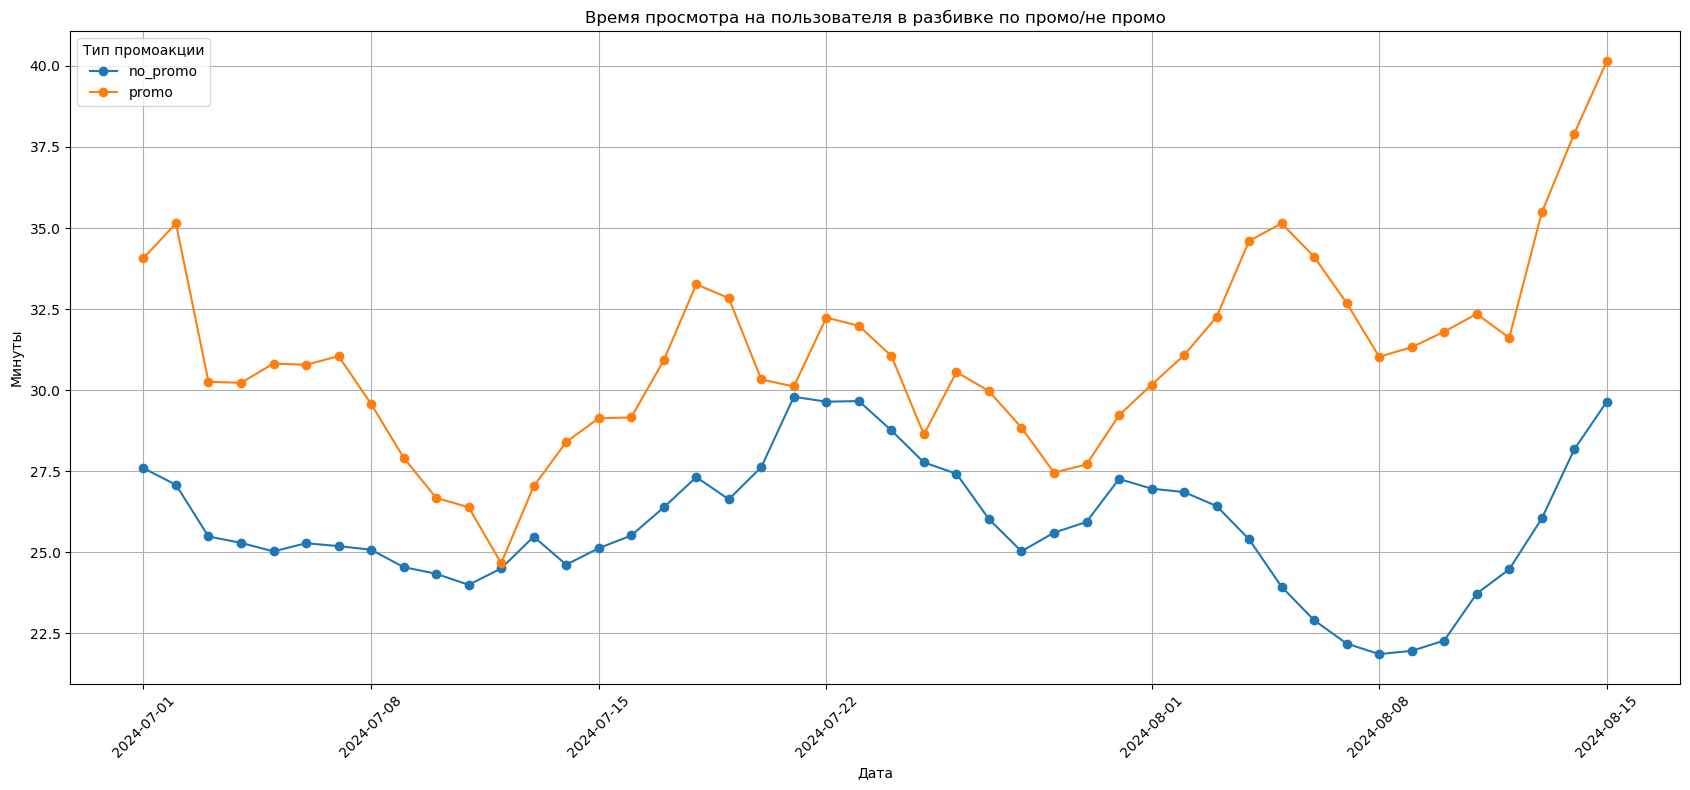

In [464]:
df_agg = df.groupby(['date_week','promo_type']).agg({'watchtime':'sum','profile_id':'nunique'}).reset_index()
df_agg.rename(columns={'profile_id':'cnt_user'},inplace=True)
df_agg['watchtime_per_user'] = df_agg.watchtime/df_agg.cnt_user/60

plt.figure(figsize=(17, 8))  

# Построение линий для каждого promo_type  
for promo in df_agg['promo_type'].unique():  
    subset = df_agg[(df_agg['promo_type'] == promo) & (df_agg['date_week']>='2024-07-01')]  
    plt.plot(subset['date_week'], subset['watchtime_per_user'], marker='o', label=promo)  

# Настройка осей и заголовка  
plt.xlabel('Дата')  
plt.ylabel('Минуты')  
plt.title('Время просмотра на пользователя в разбивке по промо/не промо')  
plt.xticks(rotation=45)  # Поворот меток по оси X  
plt.grid(True)  
plt.legend(title='Тип промоакции')  
plt.tight_layout()  # Для лучшего отображения  
plt.show() 

In [456]:
df_agg[(df_agg['date_week']>='2024-07-01')].groupby('promo_type')['watchtime_per_user'].mean().reset_index()

,promo_type,watchtime_per_user
0,no_promo,25.675345
1,promo,30.572534


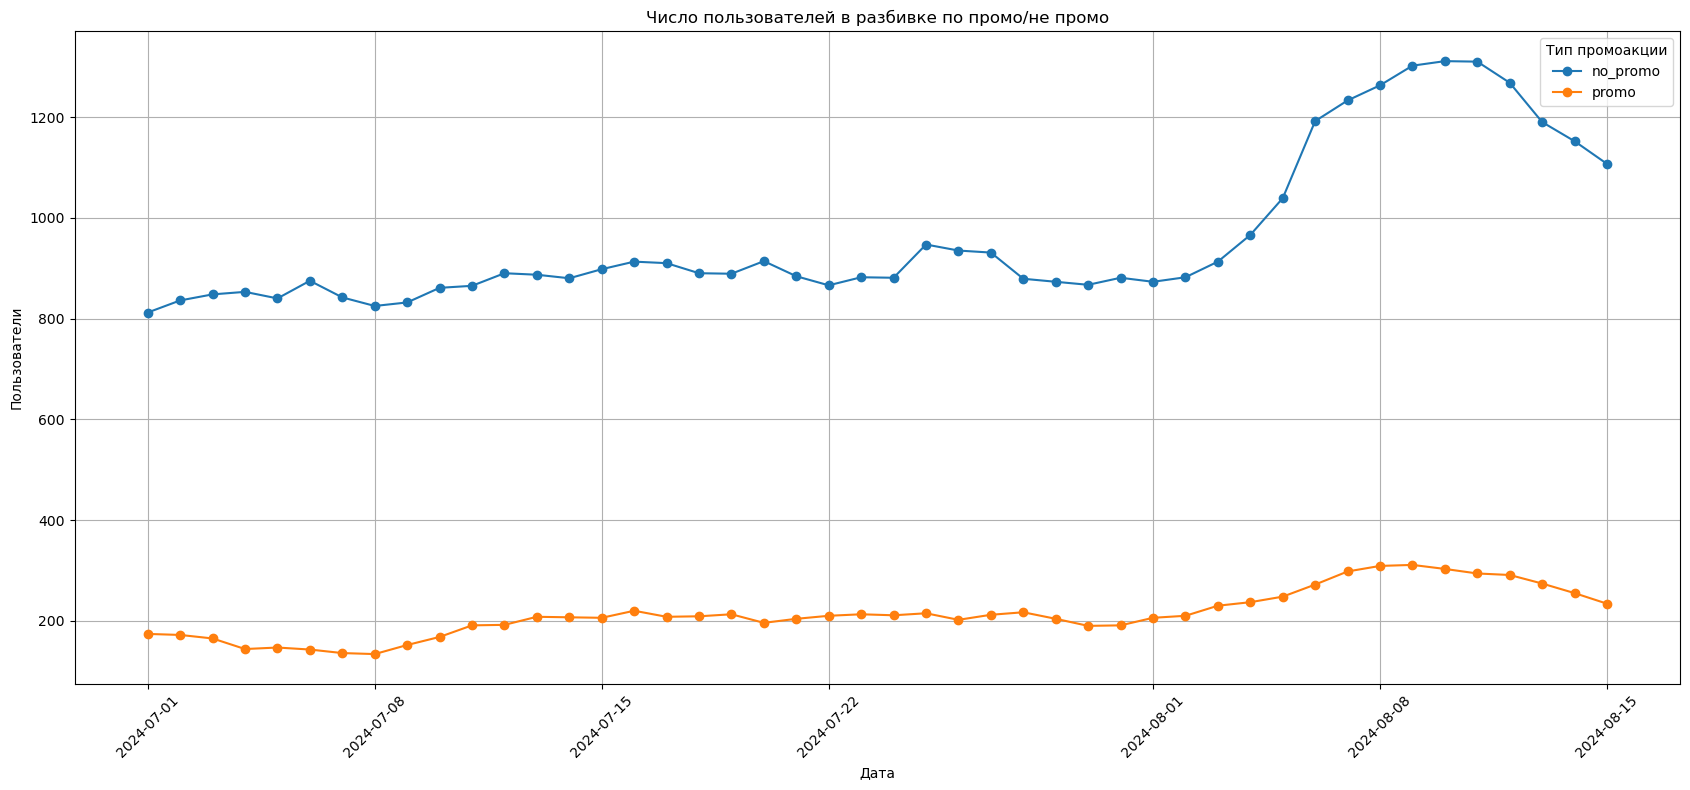

In [577]:
plt.figure(figsize=(17, 8))  

# Построение линий для каждого promo_type  
for promo in df_agg['promo_type'].unique():  
    subset = df_agg[(df_agg['promo_type'] == promo) & (df_agg['date_week']>='2024-07-01')]  
    plt.plot(subset['date_week'], subset['cnt_user'], marker='o', label=promo)  

# Настройка осей и заголовка  
plt.xlabel('Дата')  
plt.ylabel('Пользователи')  
plt.title('Число пользователей в разбивке по промо/не промо')  
plt.xticks(rotation=45)  # Поворот меток по оси X  
plt.grid(True)  
plt.legend(title='Тип промоакции')  
plt.tight_layout()  # Для лучшего отображения  
plt.show()  

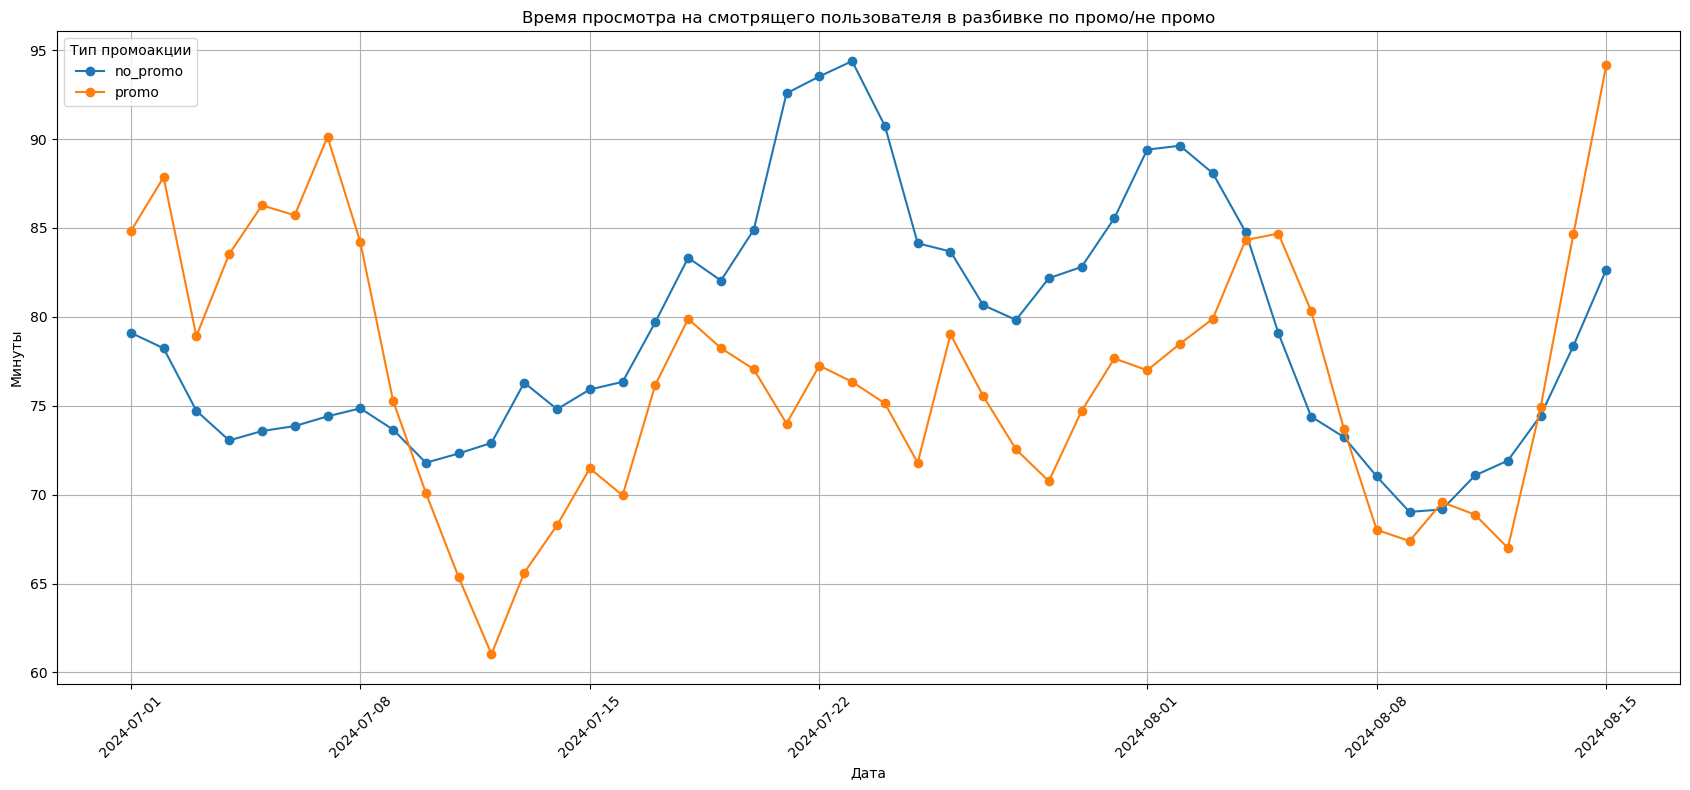

In [579]:
df_agg_cnt_user = df[df.watch_day>=1].groupby(['date_week','promo_type']).agg({'profile_id':'nunique'}).reset_index()
df_agg_watchtime = df.groupby(['date_week','promo_type']).agg({'watchtime':'sum'}).reset_index()
df_merge = pd.merge(df_agg_watchtime,df_agg_cnt_user,how='left',on=['date_week','promo_type'])
df_merge.rename(columns={'profile_id':'cnt_user'},inplace=True)
df_merge['watchtime_per_user'] = df_merge.watchtime/df_merge.cnt_user/60
df_merge
plt.figure(figsize=(17, 8))  

# Построение линий для каждого promo_type  
for promo in df_merge['promo_type'].unique():  
    subset = df_merge[(df_merge['promo_type'] == promo) & (df_merge['date_week']>='2024-07-01')]  
    plt.plot(subset['date_week'], subset['watchtime_per_user'], marker='o', label=promo)  

# Настройка осей и заголовка  
plt.xlabel('Дата')  
plt.ylabel('Минуты')  
plt.title('Время просмотра на смотрящего пользователя в разбивке по промо/не промо')  
plt.xticks(rotation=45)  # Поворот меток по оси X  
plt.grid(True)  
plt.legend(title='Тип промоакции')  
plt.tight_layout()  # Для лучшего отображения  
plt.show() 

In [532]:
list_date = pd.date_range("2024-04-01", "2024-07-31", freq='MS',normalize=True)
result = []
for date in list_date:
    date_str = date.strftime('%Y-%m-%d')
    query = f'''
            SELECT 
                '{date_str}' AS date_month,
                paid_at::date AS paid_date,
                s.user_id AS user_id,
                i.subscription_id AS subscription_id,
                s.created_at::date AS created_date,
                d.promo_type AS promo_type,
                sum(i.price_cents)/100 AS payment
                FROM  product_x.invoices i
                LEFT JOIN product_x.subscriptions s
                ON s.id = i.subscription_id
                LEFT JOIN product_x.users u 
                ON u.id = s.user_id
                LEFT JOIN (SELECT DISTINCT promo_type,user_id FROM datamarts.marketing_dash_distr) d
                on u.id=d.user_id
                WHERE u.user_type = 'regular'
                      AND u.vipplay = FALSE
                      AND s.state in ('normal_period','trial','canceled','grace_period')
                      AND DATE_TRUNC('month', paid_at::date)='{date_str}'
                      AND i.state in ('success')
                      AND i.price_cents > 100
                      AND i.price_currency = 'RUB'
                      AND d.promo_type!='cards'
                GROUP BY 1,2,3,4,5,6
            '''
    df_temp = execute(query,user = 'kmekhtiev')   
    result.append(df_temp)
    print(f"""Дата '{date_str}' загружена""")
    print()

df_payment = pd.concat(result)
df_payment['paid_date'] = df_payment['paid_date'].astype('datetime64[ns]')
df_payment['payment'] = df_payment['payment'].astype('int32')

Время выполнения функции: 7.0739 секунд

Дата '2024-04-01' загружена

Время выполнения функции: 6.5844 секунд

Дата '2024-05-01' загружена

Время выполнения функции: 6.38 секунд

Дата '2024-06-01' загружена

Время выполнения функции: 6.3769 секунд

Дата '2024-07-01' загружена



In [534]:
def calculate_weighted_avg_ltv(df_segment, user_counts):  
    segment_name = df_segment.name  
    segment_weighted_ltv = (df_segment * user_counts.loc[(slice(None), segment_name), :]).sum() / user_counts.loc[(slice(None), segment_name), :].sum()  
    return segment_weighted_ltv  


def ltv(df_pay, segment):  
    df_pay['paid_month'] = df_pay['paid_date'].dt.to_period('M')  
    df_pay = df_pay.sort_values(by=[segment, 'date_month', 'paid_month'])  
    df_ltv = df_pay.groupby(['date_month', 'paid_month', segment]).agg({'payment': 'sum', 'user_id': 'count'}).reset_index()  

    # Расчет кумулятивной суммы и добавление поля по числу пользователей когорты   
    df_ltv = df_ltv.sort_values(by=['date_month', segment, 'paid_month'])  
    df_ltv['cumulative'] = df_ltv.groupby([segment])['payment'].cumsum()  
    df_ltv['uniq_user'] = df_ltv.groupby([segment])['user_id'].transform('max')  

    # Расчет LTV  
    df_ltv['ltv'] = df_ltv.cumulative / df_ltv.uniq_user  

    # Нумерация месяцев  
    df_ltv['num_of_month'] = df_ltv.groupby([segment])['paid_month'].rank(method='first').astype('int')  

    # Сделаем pivot  
    df_pivot = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')  
    df_pivot['uniq_user'] = df_ltv.groupby(['date_month', segment])['uniq_user'].max()  

    # Создаем DataFrame с данными для расчета средневзвешенного LTV  
    weighted_ltv = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='ltv')  
    user_counts = df_ltv.pivot_table(index=['date_month', segment], columns='num_of_month', values='uniq_user')  

    weighted_avg_ltv = weighted_ltv.groupby(level=segment).apply(calculate_weighted_avg_ltv, user_counts=user_counts)  

    # Преобразуем в DataFrame  
    weighted_avg_ltv = weighted_avg_ltv.reset_index()  
    weighted_avg_ltv = weighted_avg_ltv.rename(columns={0: 'cumsum'})  

    # Преобразуем датафрейм в длинный формат с помощью melt  
    melted_df = pd.melt(weighted_avg_ltv, id_vars=[segment], var_name='num_of_month', value_name='value')  

    # Преобразуем в требуемый формат с помощью pivot  
    pivot_df = melted_df.pivot(index='num_of_month', columns=segment, values='value').reset_index()  

    plt.figure(figsize=(30, 10))  

    # Построение линий для каждого сегмента  
    for i in pivot_df.columns[1:]:  
        plt.plot(pivot_df.num_of_month, pivot_df[i], marker='o', linestyle='-', label=i)  

    plt.xlabel('Месяцы')  
    plt.ylabel('Руб')  
    plt.title('Изменение LTV по месяцам')  
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.legend(title='Segments')  
    plt.show()

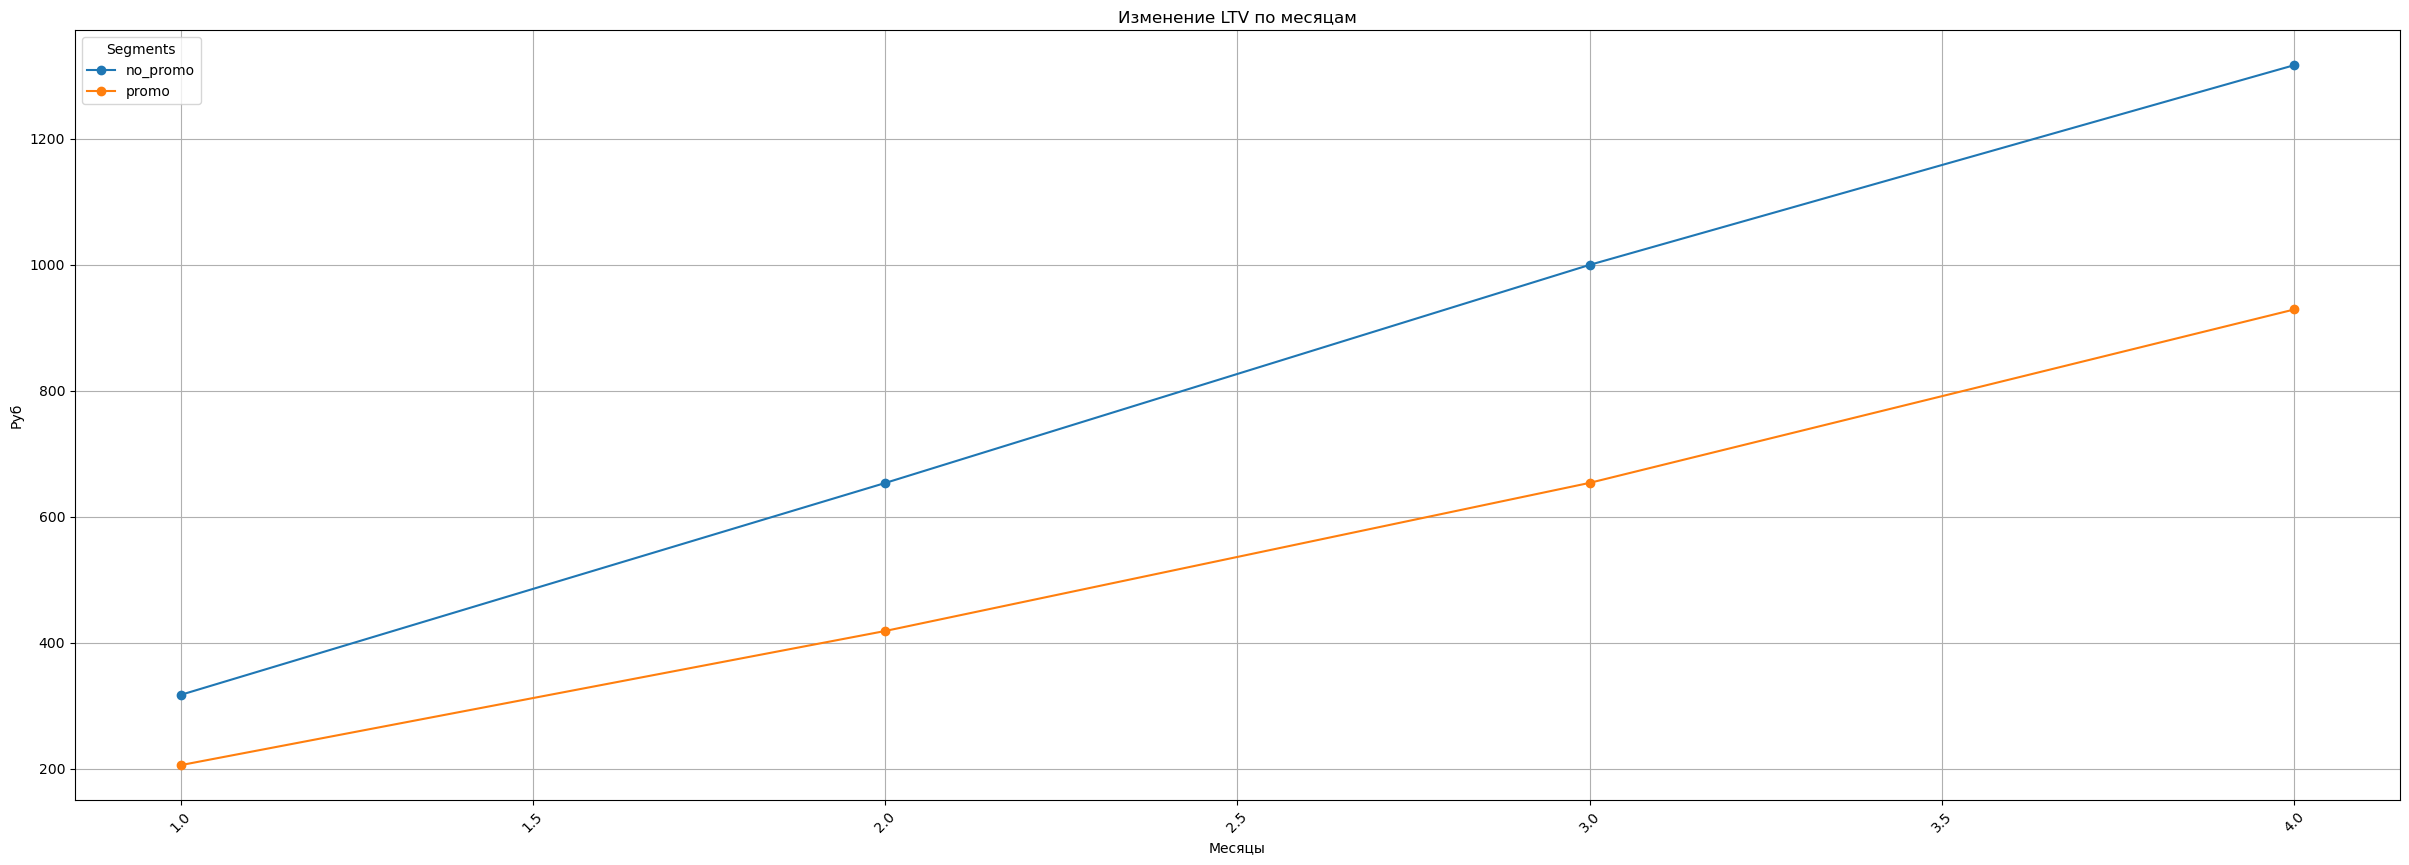

In [536]:
ltv(df_pay = df_payment,segment='promo_type')

In [596]:
query = """
SELECT 
item_title,
promo_type,
count(profile_id) as cnt_content
FROM 
(SELECT 
profile_id,
promo_type,
item_title,
sum(viewing_time) AS watchtime
FROM 
(SELECT 
                                                            date,
                                                            profile_id,
                                                            CASE WHEN client_type='android_tv' THEN 'smart_tv'
                                                                 WHEN client_type='web_mobile' THEN 'web'
                                                                 WHEN client_type='web_desktop' THEN 'web'
                                                                 WHEN client_type='Smart TV' THEN 'smart_tv'
                                                                 ELSE lower(client_type)
                                                            END AS client_type_general,
                                                            event_name,
                                                            event_page,
                                                            promo_type,
                                                            u.email,
                                                            JSONExtractInt(payload,'duration') AS duration,
                                                            JSONExtractString(payload,'item_type') AS item_type,
                                                            JSONExtractString(payload,'item_title') AS item_title,
                                                            CASE WHEN event_page<>'tvchannel'
                                                                      AND JSONExtractInt(payload,'viewing_time')<= JSONExtractInt(payload,'duration') 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                                 WHEN event_page='tvchannel' 
                                                                      AND JSONExtractInt(payload,'viewing_time') <18000 
                                                                      THEN JSONExtractInt(payload,'viewing_time')
                                                            END AS viewing_time                                  		 
                                                            FROM datamarts.sandbox_data_distr AS t1
                                                            LEFT JOIN product_x.users AS u ON t1.user_id=u.id
                                                            WHERE date BETWEEN '2024-07-01'::date AND '2024-08-15'::date
                                                            AND event_name IN ('auto_player_streaming')
                                                            AND viewing_time IS NOT NULL   
                                                            AND (u.email NOT LIKE '%@test%' OR u.email IS NULL)
                                                            AND (promo_type IS NULL OR promo_type!='cards')
           )
           GROUP BY 1,2,3
           )
           WHERE promo_type in ('promo','no_promo')
           GROUP BY 1,2
           """
df_content = execute(query,user='kmekhtiev')

Время выполнения функции: 20.3188 секунд



In [606]:
df_content = df_content[df_content['cnt_content'].notna()]

In [608]:
pd.pivot(df_content,columns='promo_type',index='item_title',values='cnt_content').reset_index().sort_values('promo',ascending = False)

promo_type,item_title,no_promo,promo
0,,4092.0,1393.0
684,Майор Гром: Чумной Доктор,225.0,165.0
718,Мертвый сезон,54.0,118.0
582,Король неба,41.0,89.0
22,57 секунд,32.0,80.0
...,...,...,...
1416,Эбигейл,2.0,NaN
1422,Экстремальные спасатели,2.0,NaN
1426,Эспен в поисках Золотого замка,1.0,NaN
1428,Это моя собака,2.0,NaN
